## Importing the necessary modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()
from scipy import stats

from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import metrics

import joblib

import warnings # to avoid warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/homebrew/anaconda3/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Loading the dataset

In [2]:
df = pd.read_csv('weatherDataset.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
# dimension of the dataframe
df.shape

(145460, 23)

In [4]:
# features names
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

## No. of missing values column-wise

In [6]:
missingValues = df.isnull().sum().sort_values(ascending=False)
missingValues

Sunshine         69835
Evaporation      62790
Cloud3pm         59358
Cloud9am         55888
Pressure9am      15065
Pressure3pm      15028
WindDir9am       10566
WindGustDir      10326
WindGustSpeed    10263
Humidity3pm       4507
WindDir3pm        4228
Temp3pm           3609
RainTomorrow      3267
Rainfall          3261
RainToday         3261
WindSpeed3pm      3062
Humidity9am       2654
Temp9am           1767
WindSpeed9am      1767
MinTemp           1485
MaxTemp           1261
Location             0
Date                 0
dtype: int64

## Segregating into numerical and categorical features

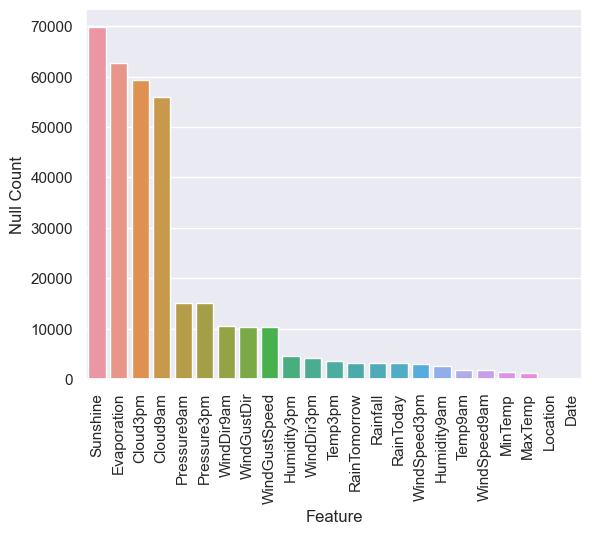

In [7]:
# Visualizing the missing values count
missingValues = missingValues.to_frame()
missingValues.columns = ['Null Count']
missingValues.index.names = ['Feature']
missingValues['Feature'] = missingValues.index
sns.barplot(x='Feature', y='Null Count', data=missingValues)

plt.xticks(rotation = 90)
plt.show()

In [8]:
numericalFeatures = [feature for feature in df.columns if df[feature].dtype != 'object']
categoricalFeatures = [feature for feature in df.columns if df[feature].dtype == 'object']
discreteFeatures = [feature for feature in numericalFeatures if len(df[feature].unique()) <= 25]
continuousFeatures = [feature for feature in numericalFeatures if feature not in discreteFeatures]

In [9]:
'Numerical Features: ' + str(numericalFeatures)

"Numerical Features: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']"

In [10]:
'Discrete Features: '+ str(discreteFeatures)

"Discrete Features: ['Cloud9am', 'Cloud3pm']"

In [11]:
'Continuous Features: '+ str(continuousFeatures)

"Continuous Features: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']"

In [12]:
'Categorical Features: ' + str(categoricalFeatures)

"Categorical Features: ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']"

## Features Analysis

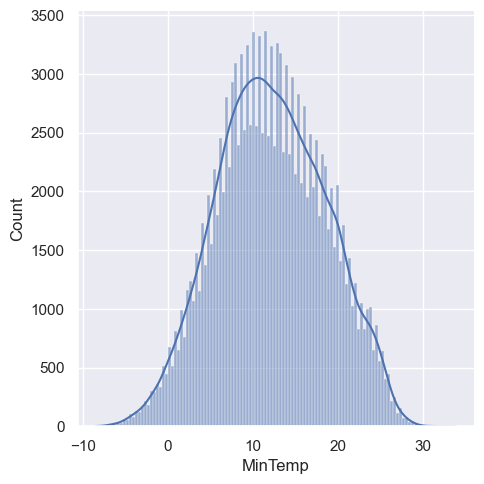

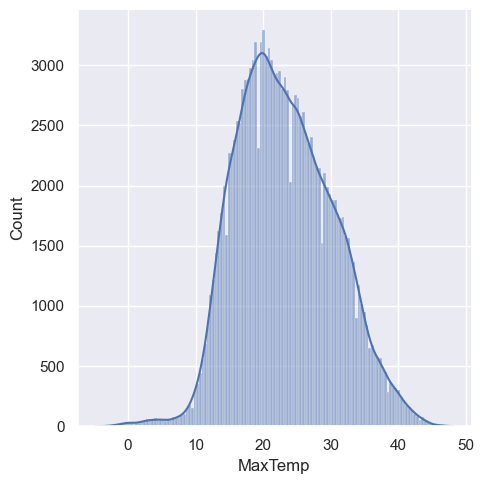

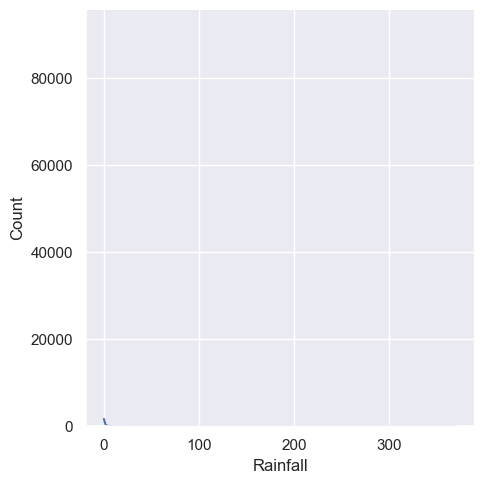

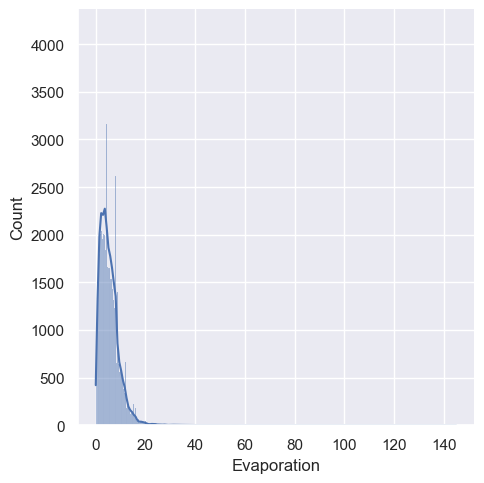

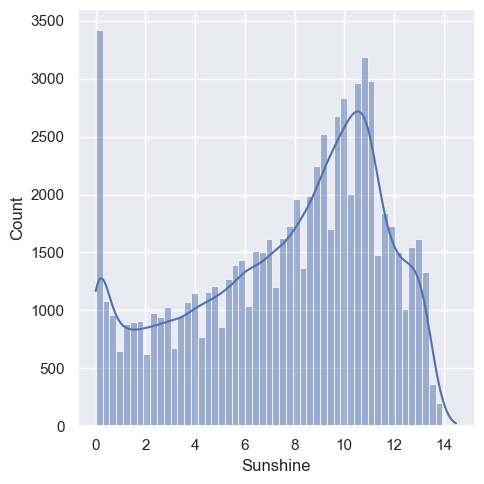

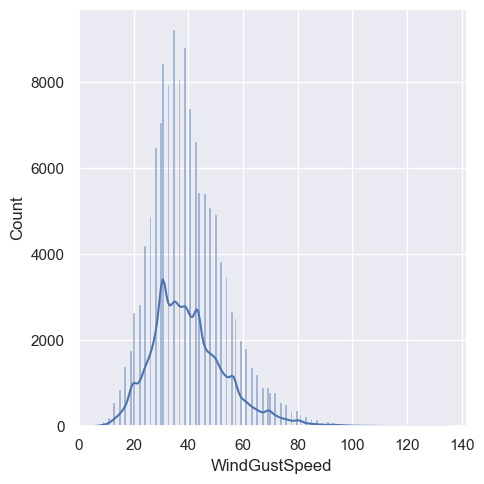

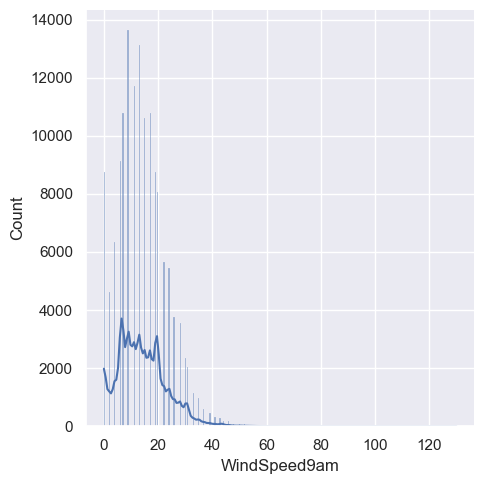

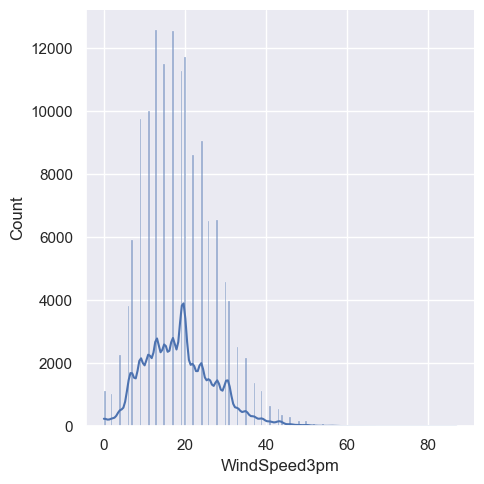

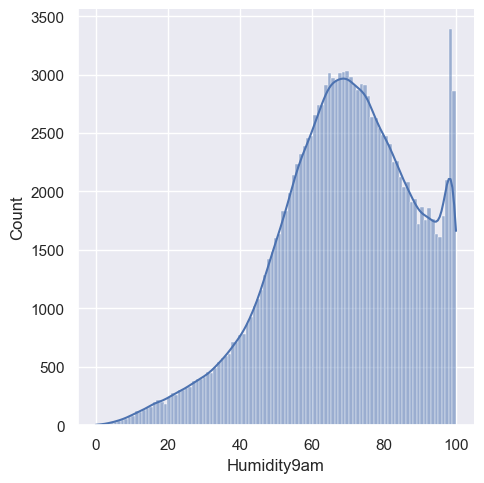

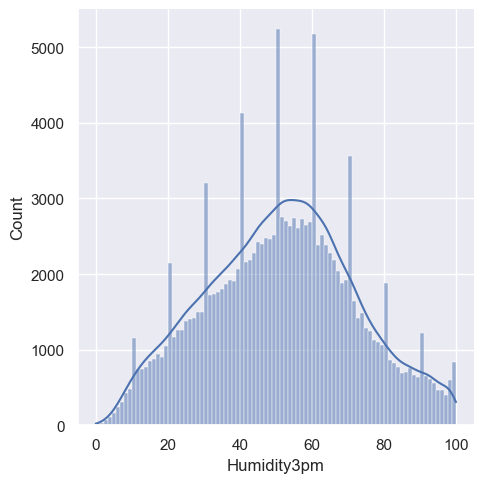

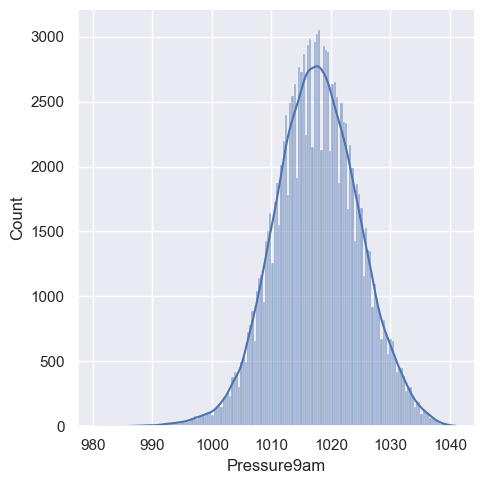

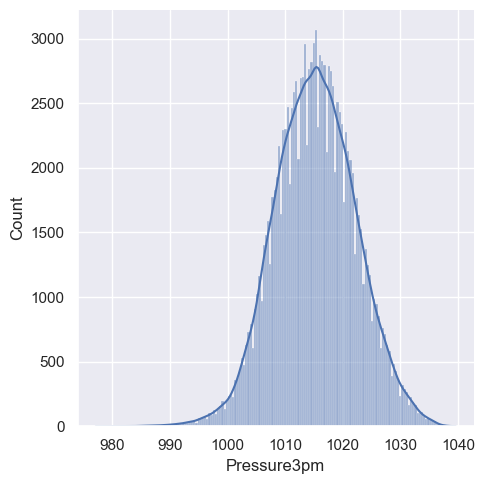

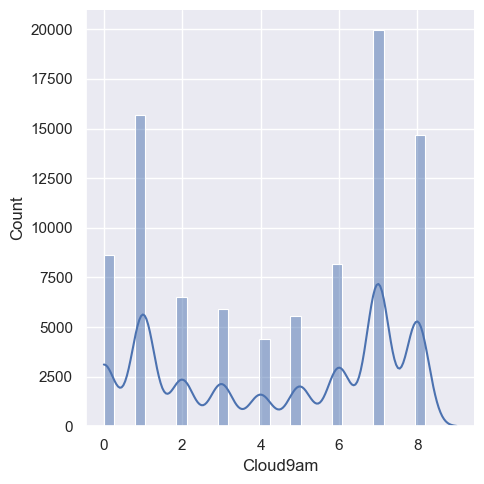

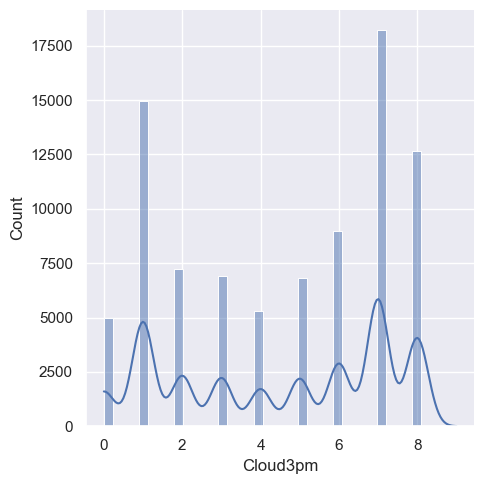

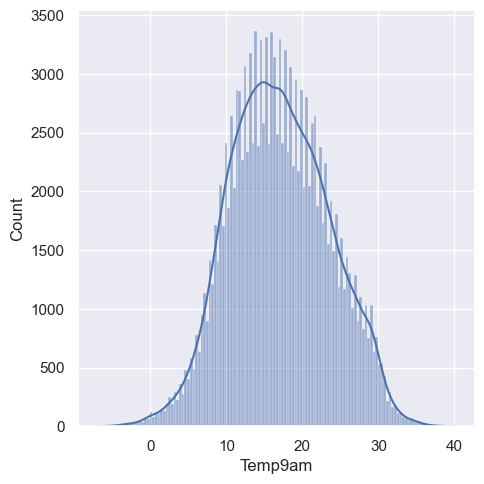

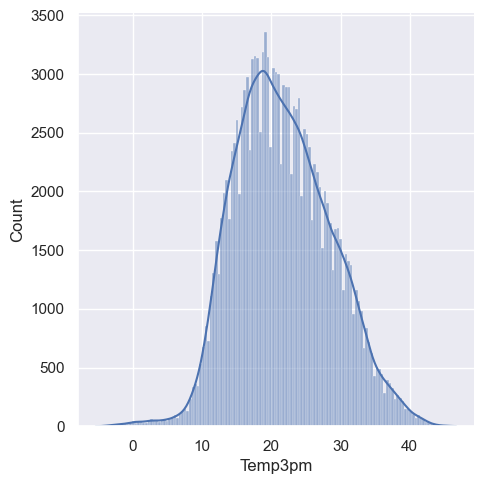

In [13]:
for feature in numericalFeatures:
    sns.displot(df[feature], kde=True)
    plt.show()

## Correlation between the features

<AxesSubplot:>

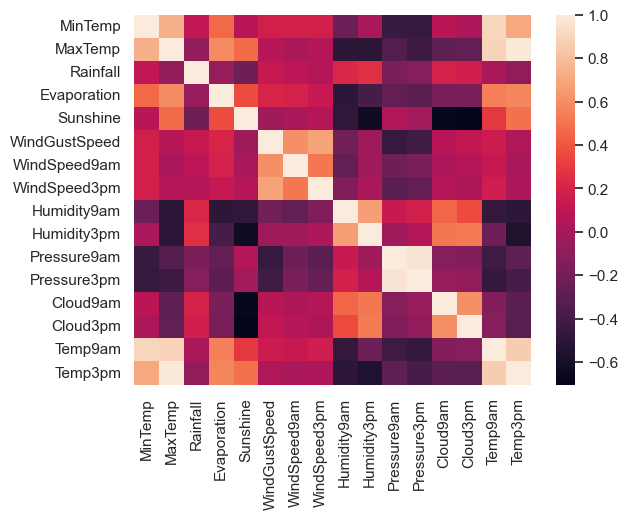

In [14]:
sns.heatmap(df.corr())

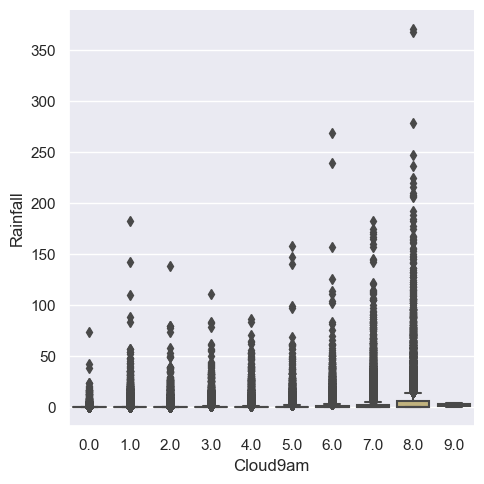

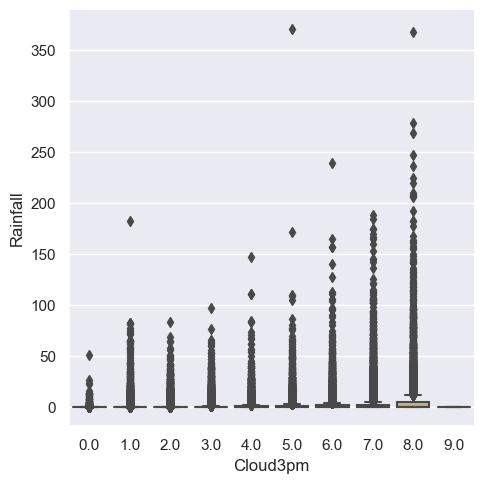

In [15]:
for feature in discreteFeatures:
    sns.catplot(x=feature, y='Rainfall', data=df, kind = 'box')

<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

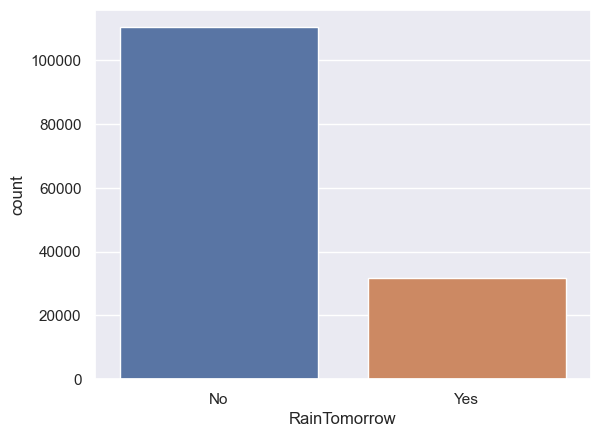

In [16]:
# to check if data is balanced or not
sns.countplot(x='RainTomorrow', data=df)

## Handling Null Values

In [17]:
# to avoid problems in transformation
# mean does not work if outliers are present but median works(variance distorted)
# store non-missing values into missing values indices -> variance is not distorted

In [18]:
df.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [19]:
def randomSampleImputation(df, col):
    randomSample = df[col].dropna().sample(df[col].isnull().sum(), random_state = 0)
    randomSample.index = df[df[col].isnull()].index
    df.loc[df[col].isnull(),col] = randomSample

In [20]:
randomSampleImputation(df, 'Cloud9am')
randomSampleImputation(df, 'Cloud3pm')
randomSampleImputation(df, 'Evaporation')
randomSampleImputation(df, 'Sunshine')

In [21]:
categoricalFeatures

['Date',
 'Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow']

In [22]:
df['RainToday'] = pd.get_dummies(df['RainToday'], drop_first = True)
df['RainTomorrow'] = pd.get_dummies(df['RainTomorrow'], drop_first = True)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,2.4,8.3,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0
1,2008-12-02,Albury,7.4,25.1,0.0,3.6,10.0,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0
2,2008-12-03,Albury,12.9,25.7,0.0,2.6,4.4,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0
3,2008-12-04,Albury,9.2,28.0,0.0,18.4,8.9,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0
4,2008-12-05,Albury,17.5,32.3,1.0,5.4,3.0,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,1.4,7.8,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0
145456,2017-06-22,Uluru,3.6,25.3,0.0,7.6,13.5,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0
145457,2017-06-23,Uluru,5.4,26.9,0.0,6.8,11.0,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0
145458,2017-06-24,Uluru,7.8,27.0,0.0,2.6,13.2,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0


In [23]:
continuousFeatures

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm']

In [24]:
for f in continuousFeatures:
    if df[f].isnull().sum()*100/len(df) > 0:
        df[f] = df[f].fillna(df[f].median())

In [25]:
for f in categoricalFeatures:
    print(f, (df.groupby([f])['RainTomorrow'].mean().sort_values(ascending = False)).index)

Date Index(['2007-11-01', '2007-12-15', '2008-02-03', '2008-01-31', '2008-01-30',
       '2008-01-19', '2008-01-18', '2008-01-16', '2008-01-12', '2007-11-30',
       ...
       '2008-05-08', '2008-05-09', '2008-01-03', '2008-01-02', '2008-05-10',
       '2008-05-11', '2008-05-12', '2008-05-13', '2008-05-14', '2007-12-25'],
      dtype='object', name='Date', length=3436)
Location Index(['Portland', 'Walpole', 'Cairns', 'Dartmoor', 'NorfolkIsland',
       'MountGambier', 'Albany', 'Witchcliffe', 'CoffsHarbour', 'MountGinini',
       'NorahHead', 'Darwin', 'Sydney', 'SydneyAirport', 'Ballarat',
       'GoldCoast', 'Watsonia', 'Newcastle', 'Hobart', 'Wollongong',
       'Williamtown', 'Launceston', 'Brisbane', 'MelbourneAirport', 'Adelaide',
       'Sale', 'Albury', 'Perth', 'Melbourne', 'Nuriootpa', 'Penrith',
       'BadgerysCreek', 'PerthAirport', 'Tuggeranong', 'Richmond', 'Bendigo',
       'Canberra', 'WaggaWagga', 'Townsville', 'Katherine', 'PearceRAAF',
       'SalmonGums', 'Nhil', 

In [26]:
windgustdir_map = {'NNW' : 0, 'NW' : 1, 'WNW' : 2, 'N' : 3, 'W' : 4, 'WSW' : 5, 'NNE' : 6, 'S' : 7, 'SSW' : 8,
                   'SW' : 9, 'SSE' : 10,'NE' : 11, 'SE' : 12, 'ESE' : 13, 'ENE' : 14, 'E' : 15}
winddir9am_map = {'NNW' : 0, 'N' : 1, 'NW' : 2, 'NNE' : 3, 'WNW' : 4, 'W' : 5, 'WSW' : 6, 'SW' : 7, 'SSW' : 8,
                  'NE' : 9, 'S' : 10, 'SSE' : 11, 'ENE' : 12, 'SE' : 13, 'ESE' : 14, 'E' : 15} 
winddir3pm_map = {'NW' : 0, 'NNW' : 1, 'N' : 2, 'WNW' : 3, 'W' : 4, 'NNE' : 5, 'WSW' : 6, 'SSW' : 7, 'S' : 8,
                  'SW' : 9, 'SE' : 10, 'NE' : 11, 'SSE' : 12, 'ENE' : 13, 'E' : 14, 'ESE' : 15}

In [27]:
df['WindGustDir'] = df['WindGustDir'].map(windgustdir_map)
df['WindDir9am'] = df['WindDir9am'].map(winddir9am_map)
df['WindDir3pm'] = df['WindDir3pm'].map(winddir3pm_map)

In [28]:
def fillByMode(df, f):
    mode = df[f].value_counts().index[0]
    df[f].fillna(mode, inplace = True)

In [29]:
fillByMode(df, 'WindGustDir')
fillByMode(df, 'WindDir9am')
fillByMode(df, 'WindDir3pm')

In [30]:
df.isnull().sum()*100/len(df)

Date             0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
dtype: float64

## Handling Outliers

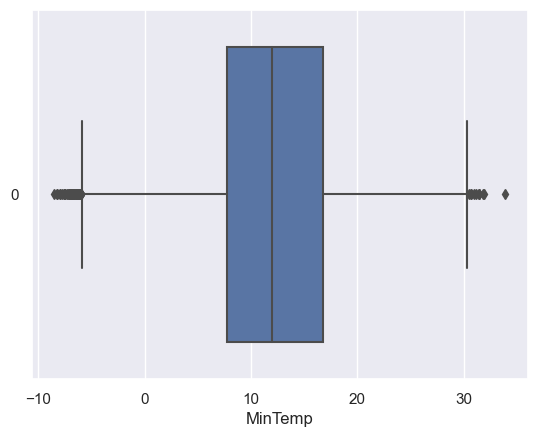

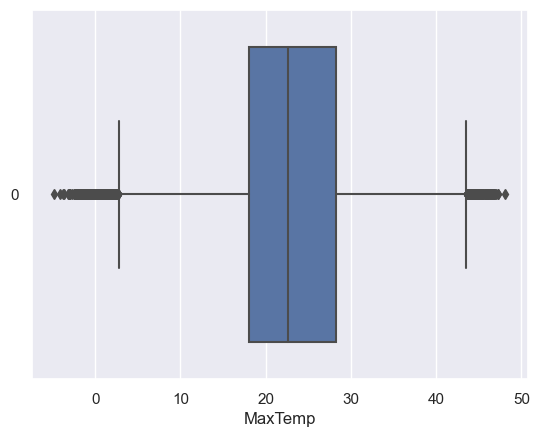

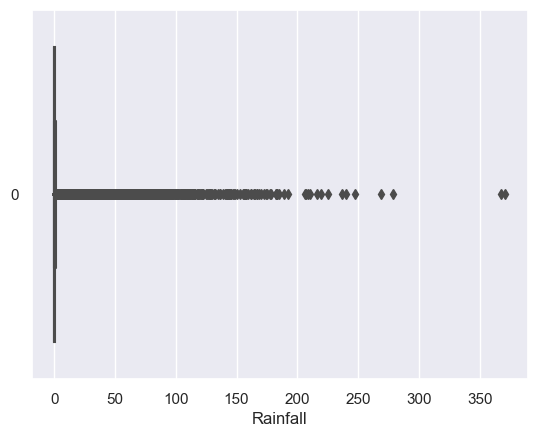

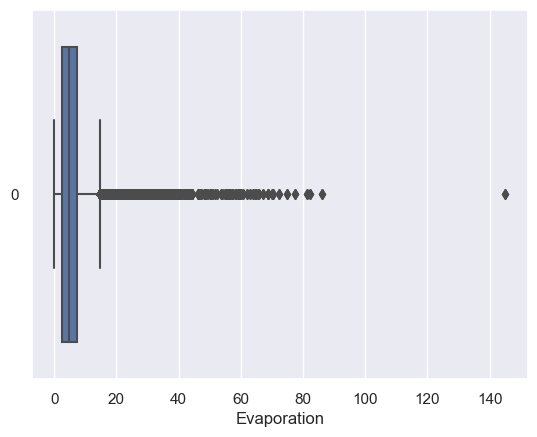

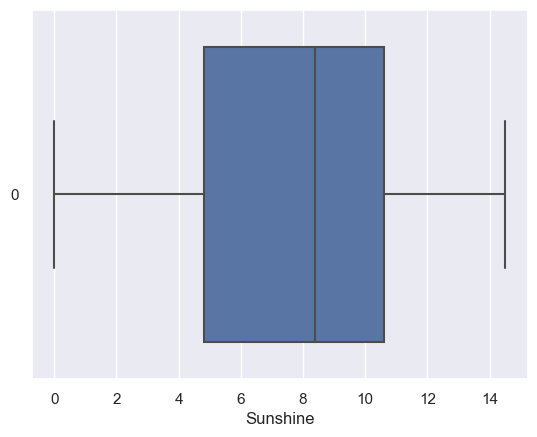

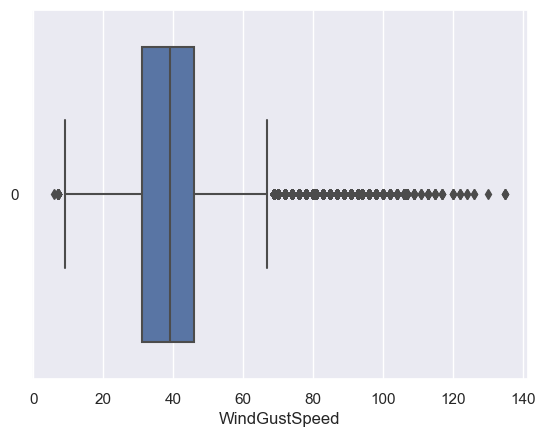

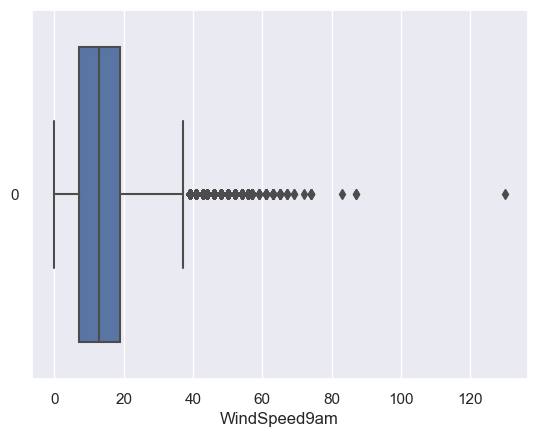

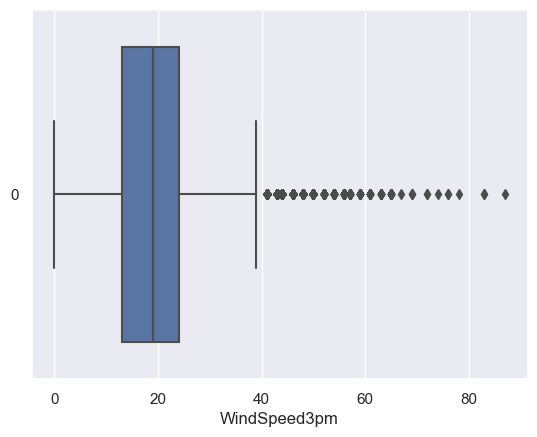

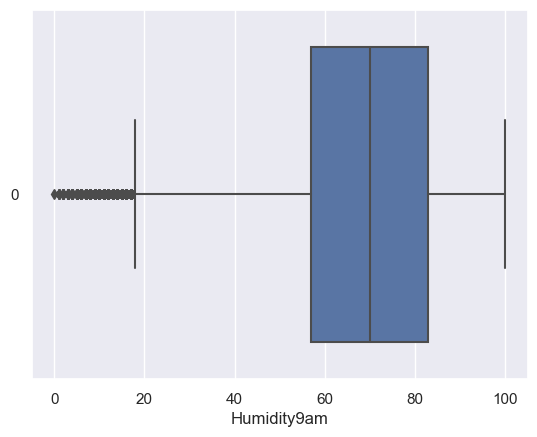

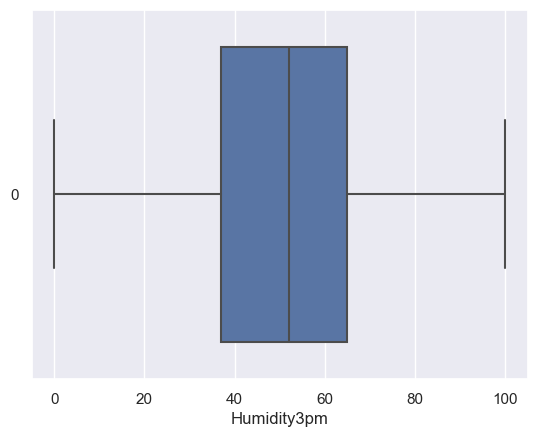

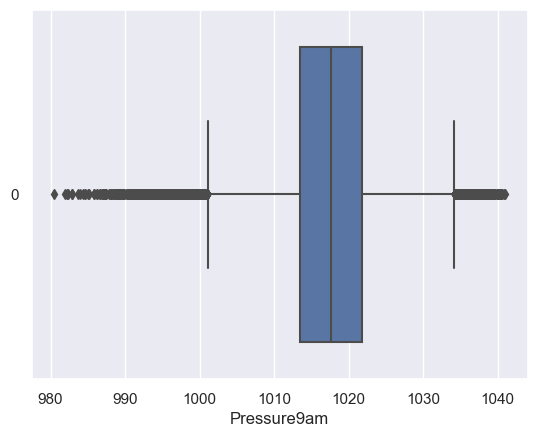

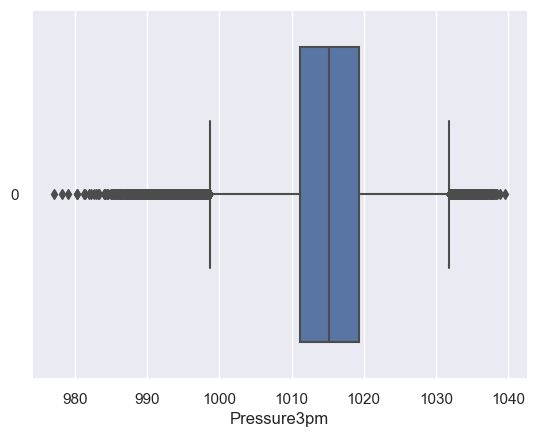

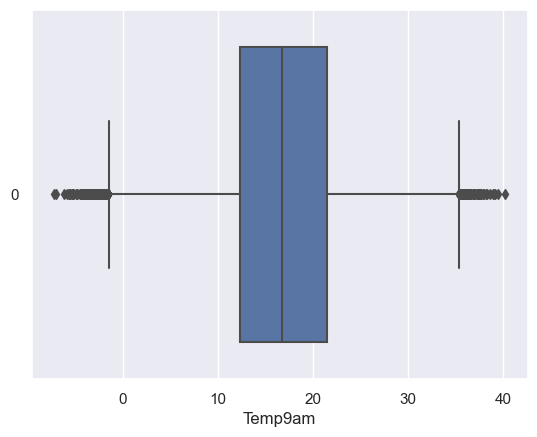

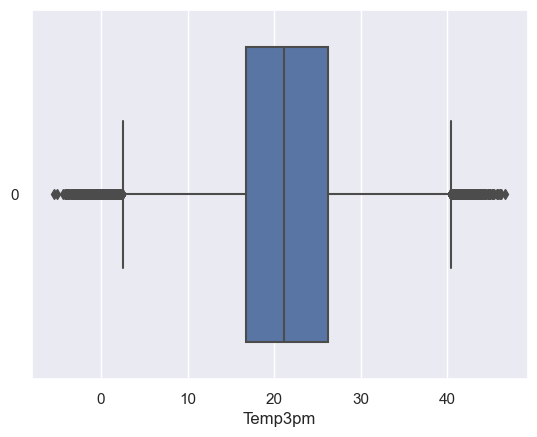

In [31]:
for feature in continuousFeatures:
    sns.boxplot(df[feature], orient = 'h')
    plt.xlabel(feature)
    plt.show()

In [32]:
def removeOutliers(df, feature):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    IQR = q3 - q1
    l = q3 - (IQR*1.5)
    u = q1 + (IQR*1.5)
    
    df.loc[df[feature]>=u, feature] = round(u,2)
    df.loc[df[feature]<=l, feature] = round(l,2)

In [33]:
for f in continuousFeatures:
    removeOutliers(df, f)

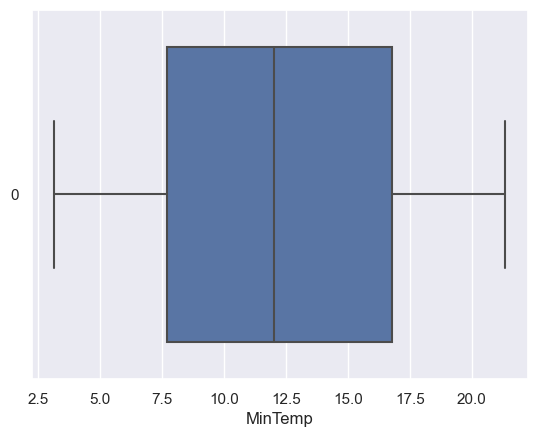

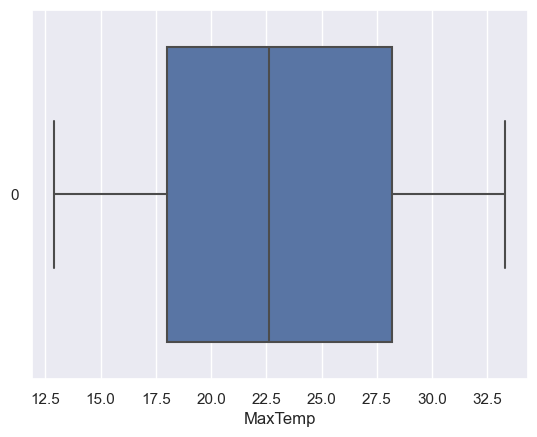

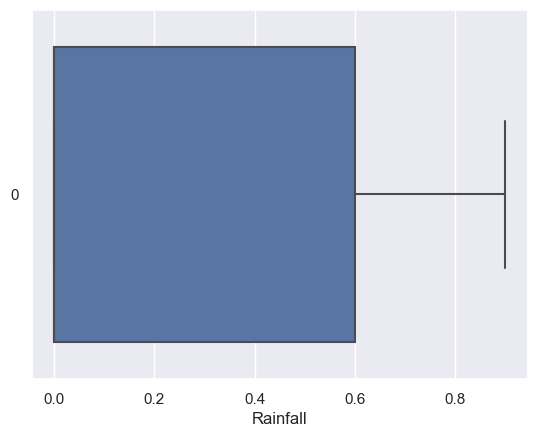

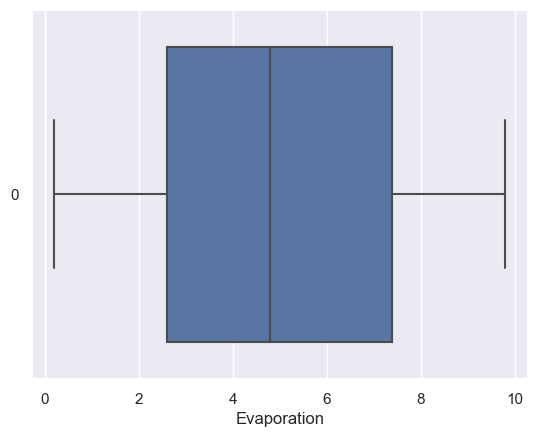

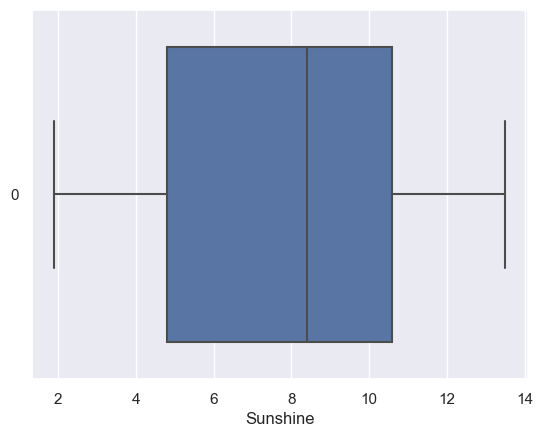

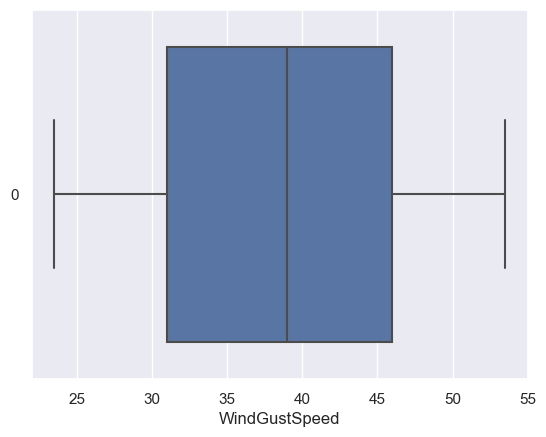

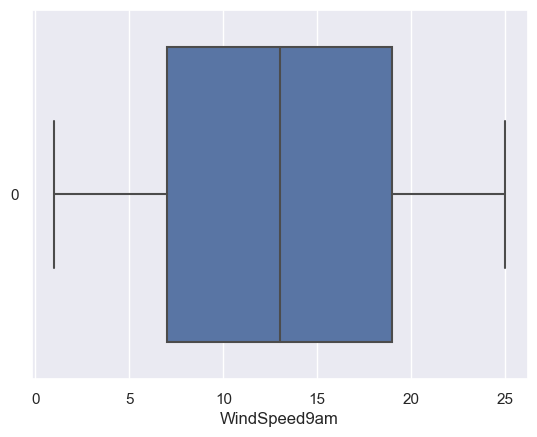

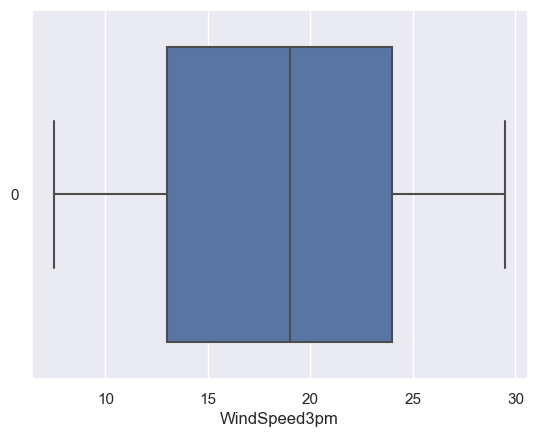

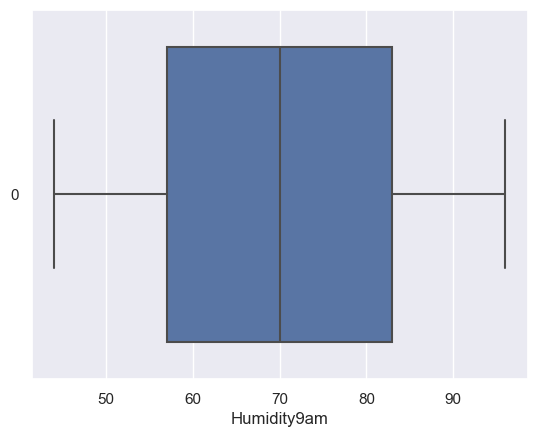

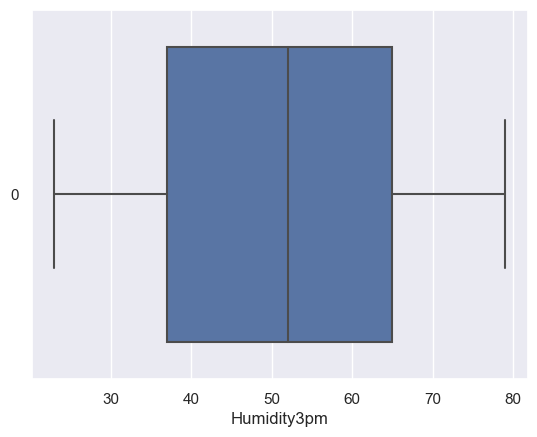

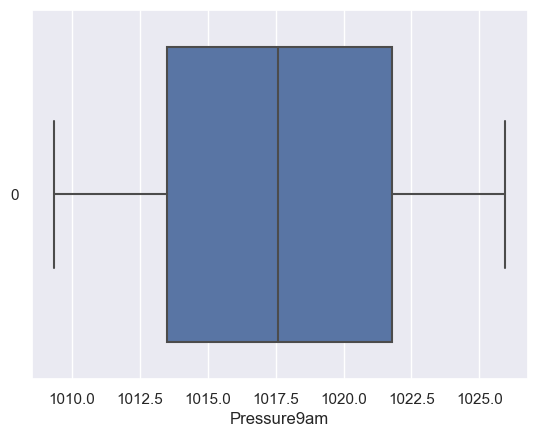

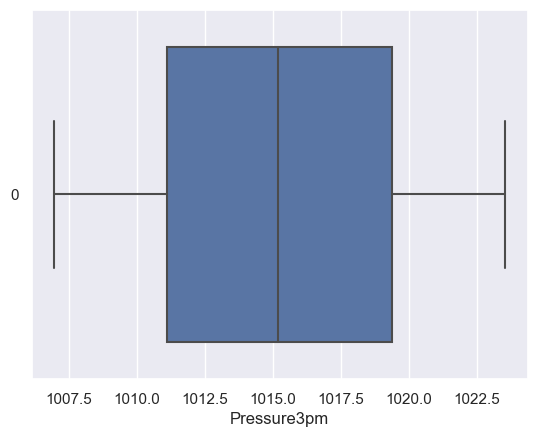

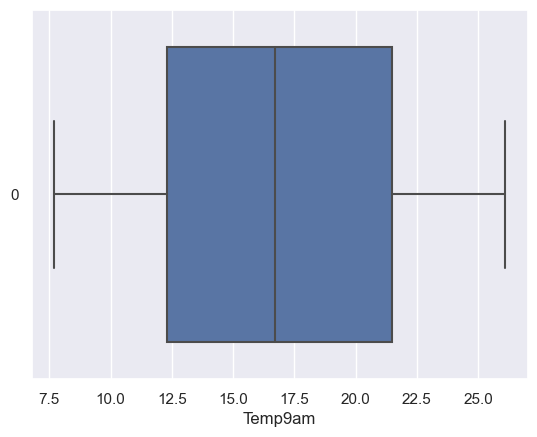

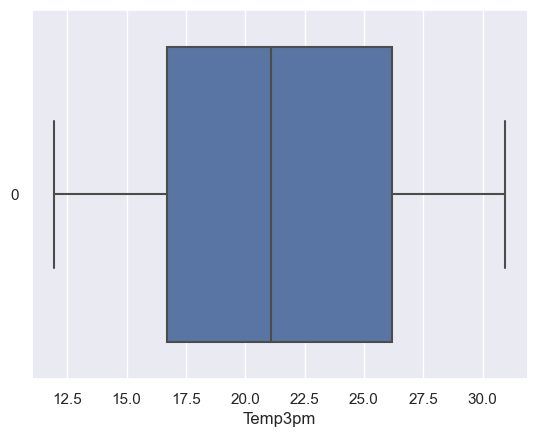

In [34]:
for feature in continuousFeatures:
    sns.boxplot(df[feature], orient = 'h')
    plt.xlabel(feature)
    plt.show()

In [35]:
def qq_plot(df, feature):
    print(feature)
    plt.figure(figsize = (15,6))
    plt.subplot(1,2,1)
    df[feature].hist()
    
    plt.subplot(1,2,2)
    stats.probplot(df[feature], dist = 'norm', plot = plt)
    plt.show()

MinTemp


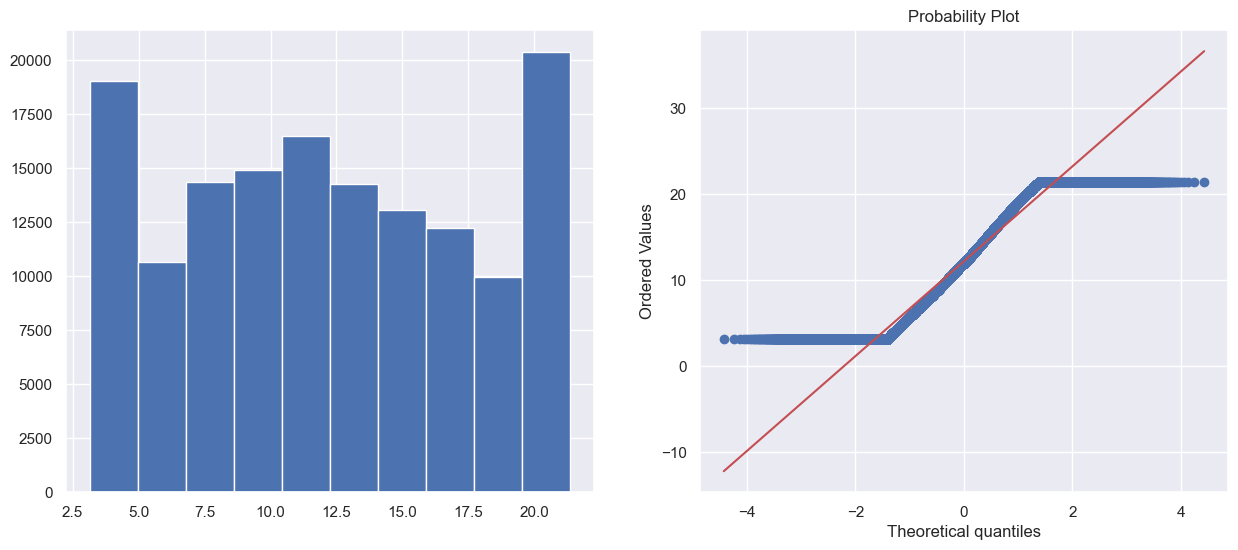

MaxTemp


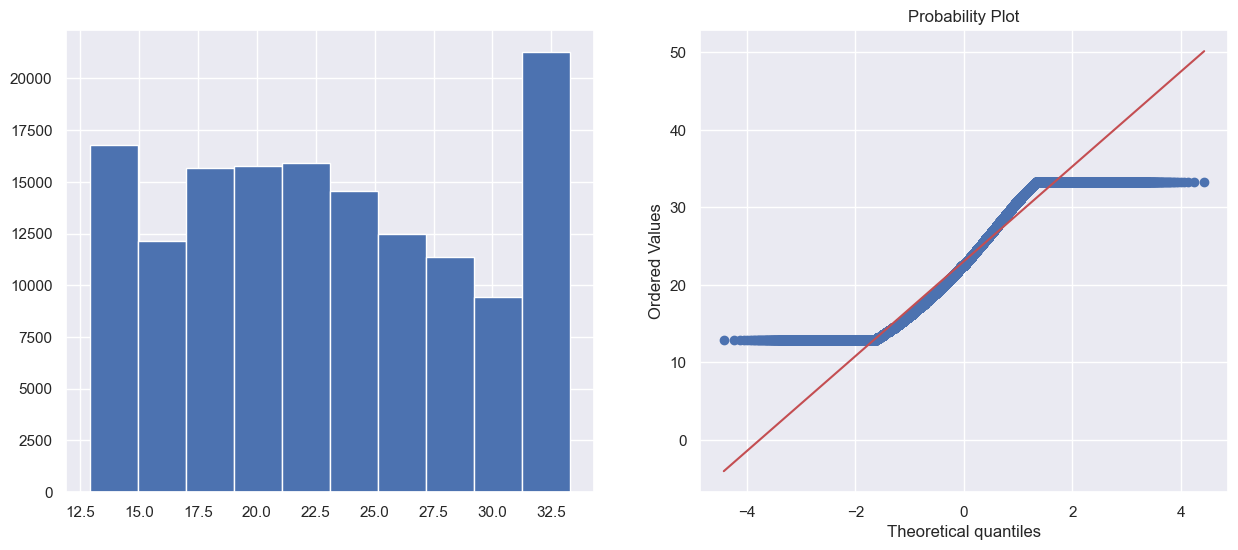

Rainfall


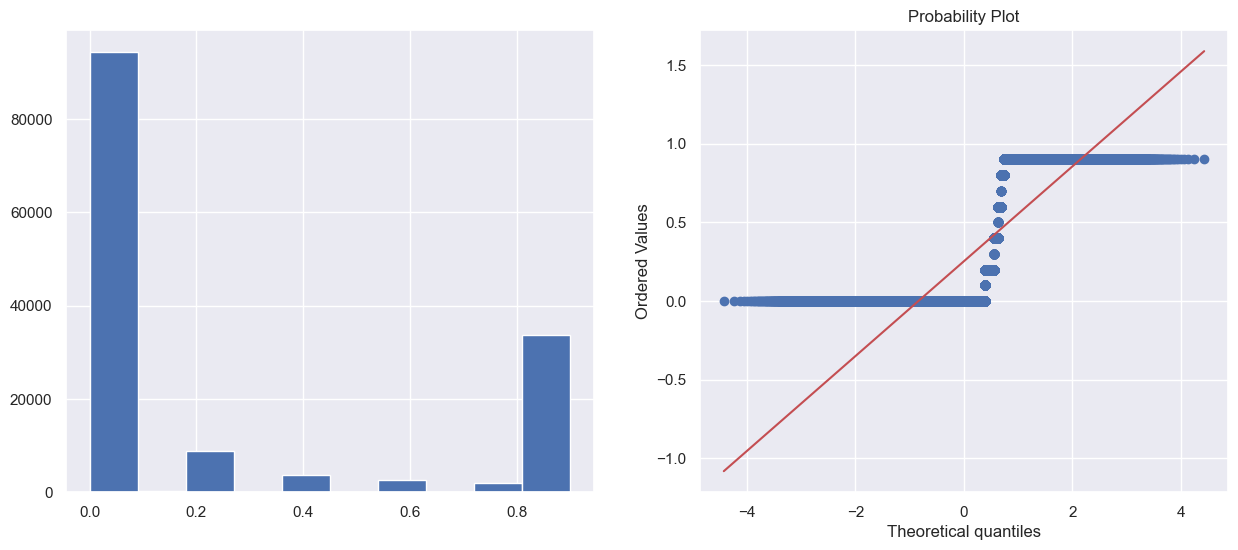

Evaporation


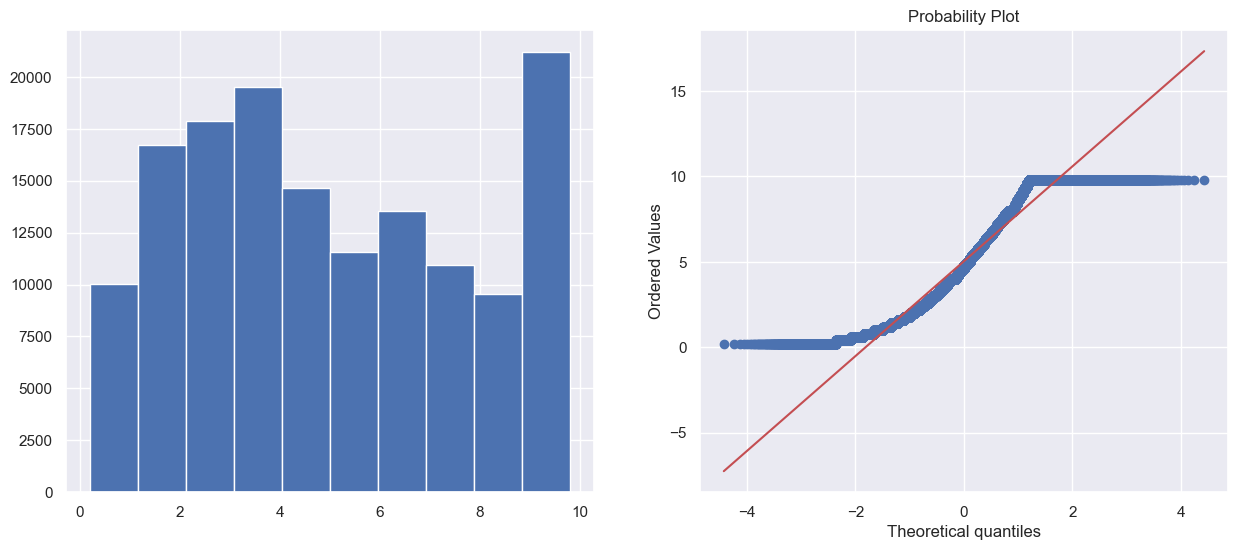

Sunshine


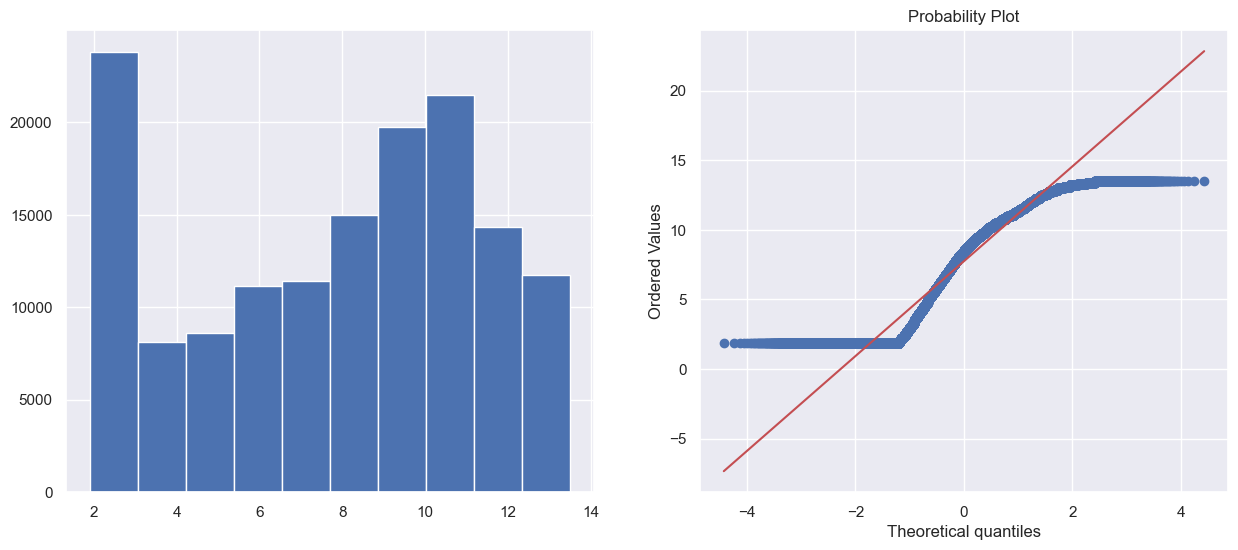

WindGustSpeed


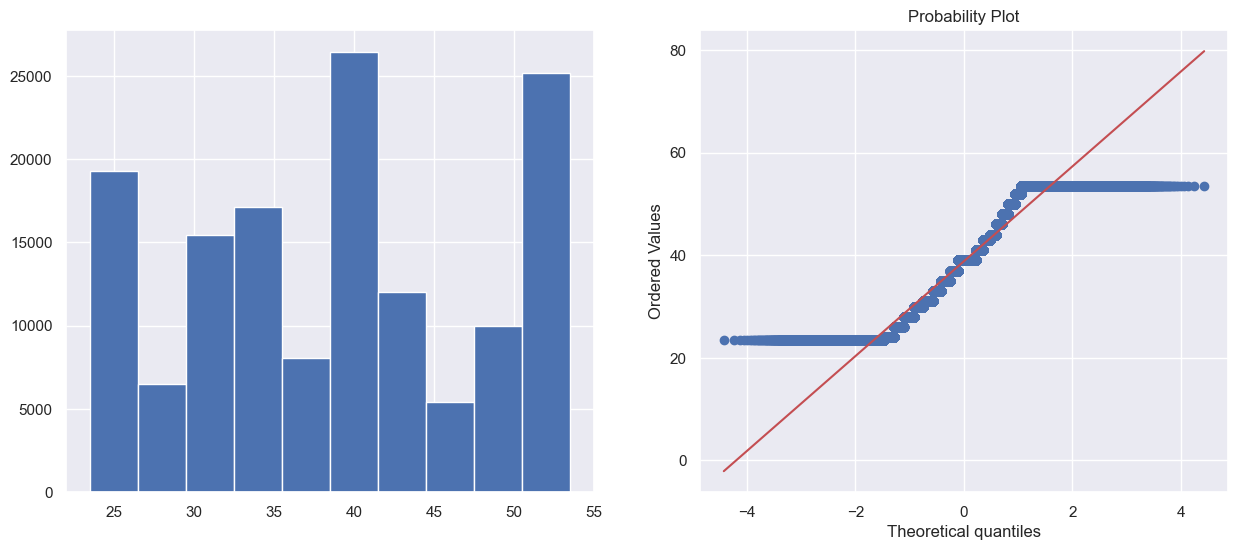

WindSpeed9am


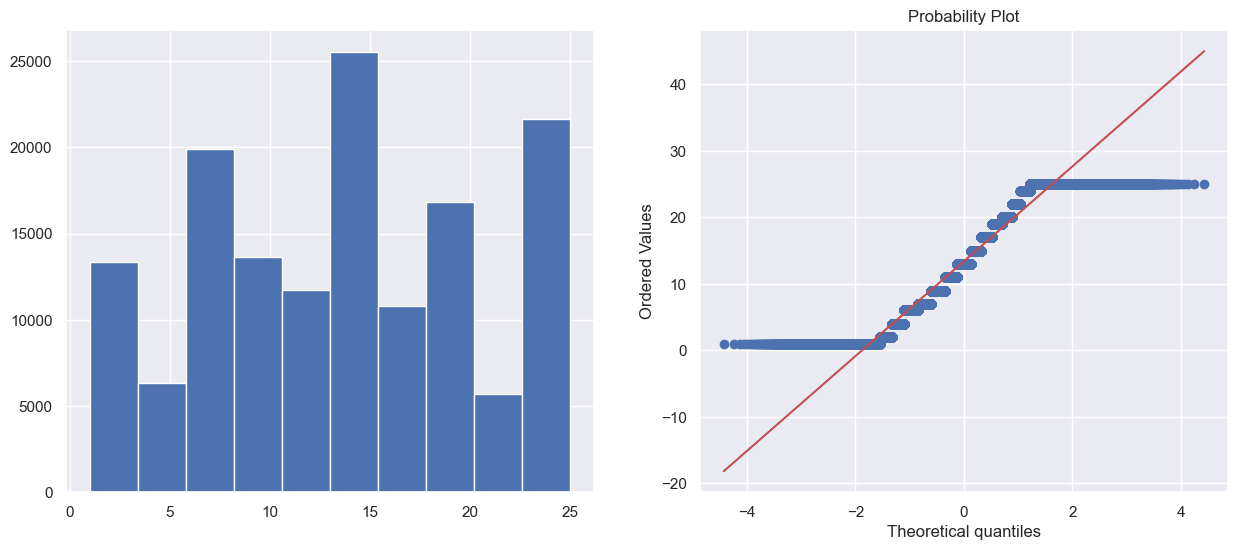

WindSpeed3pm


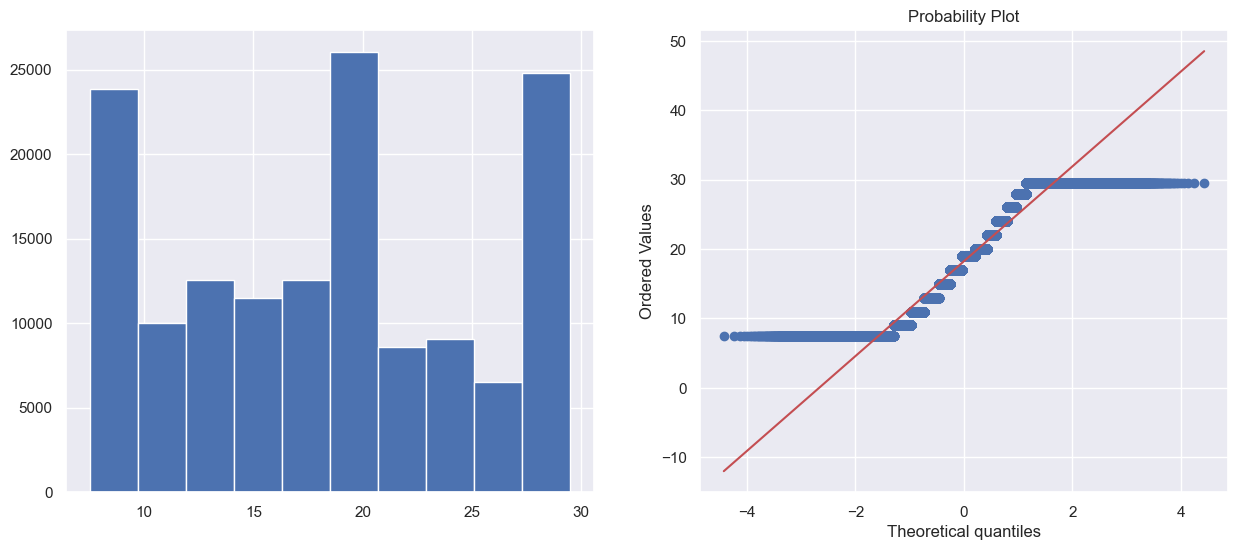

Humidity9am


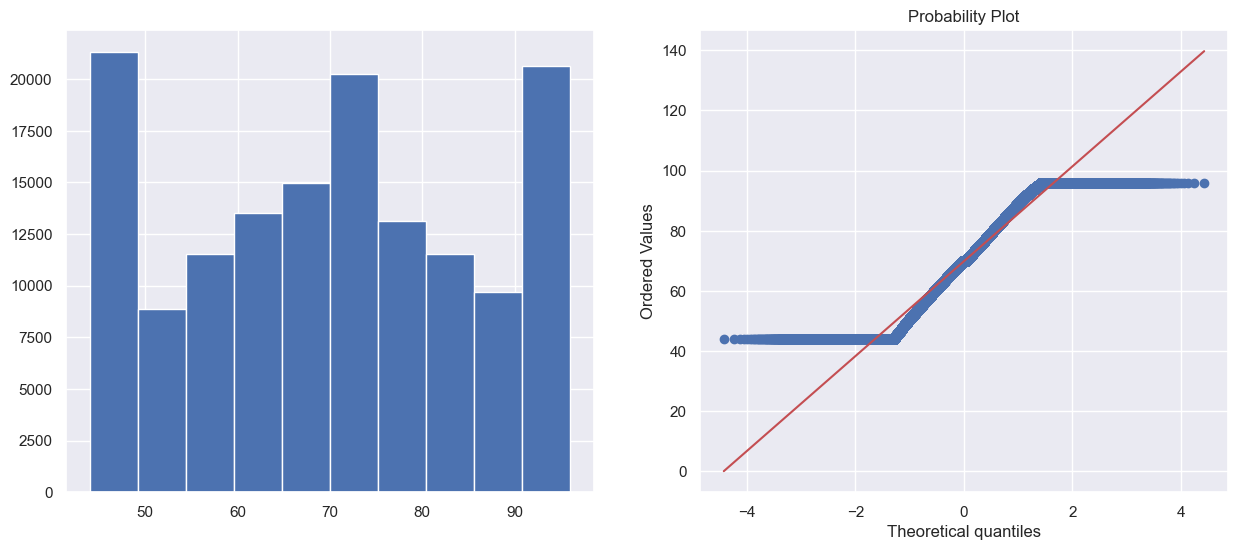

Humidity3pm


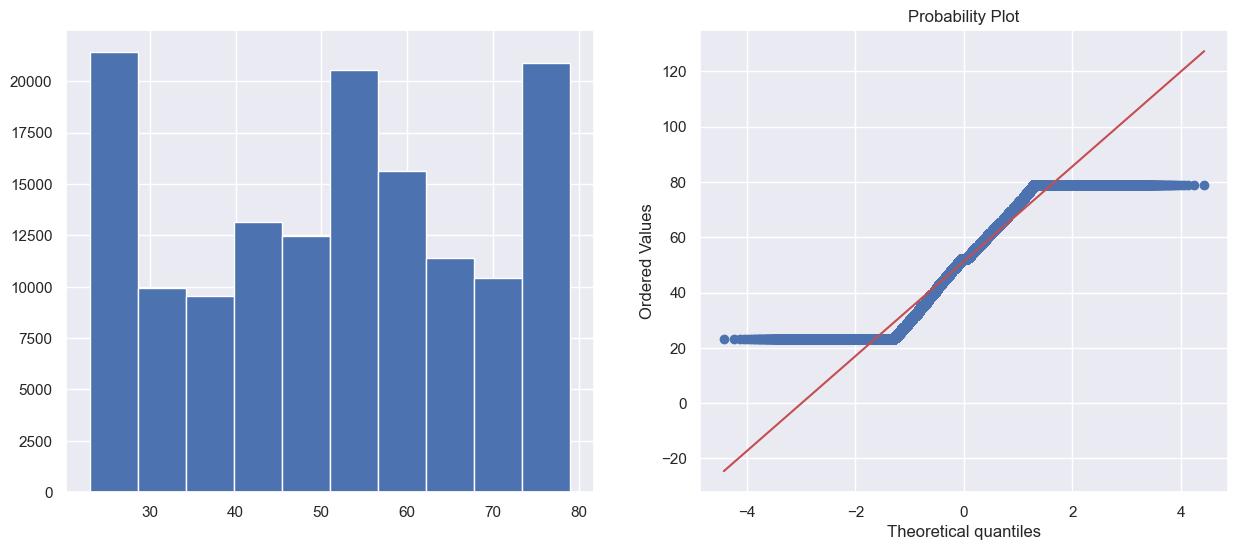

Pressure9am


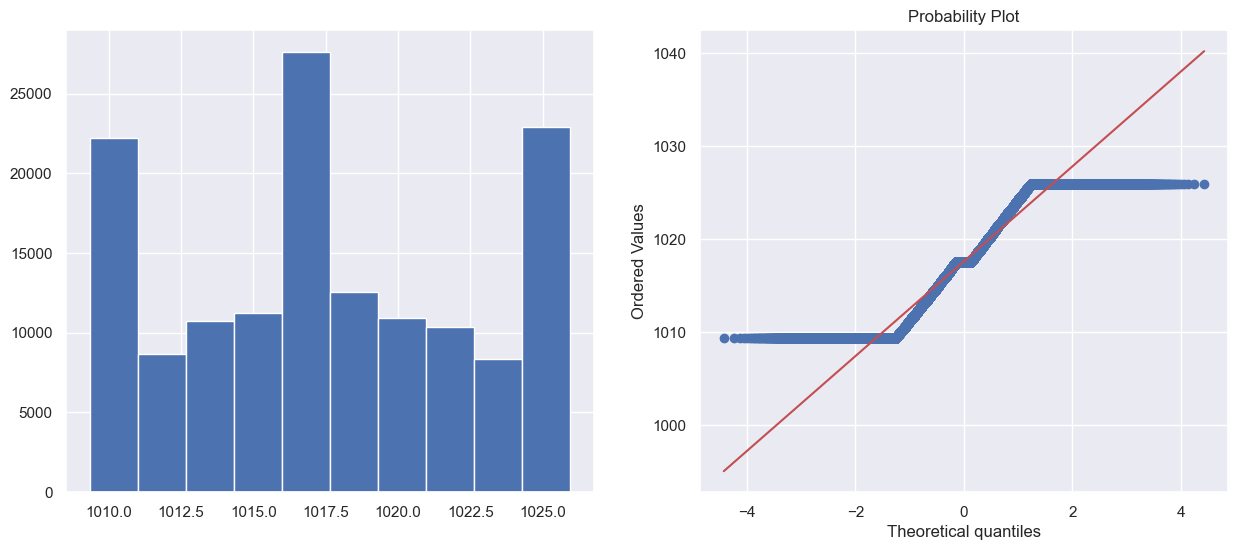

Pressure3pm


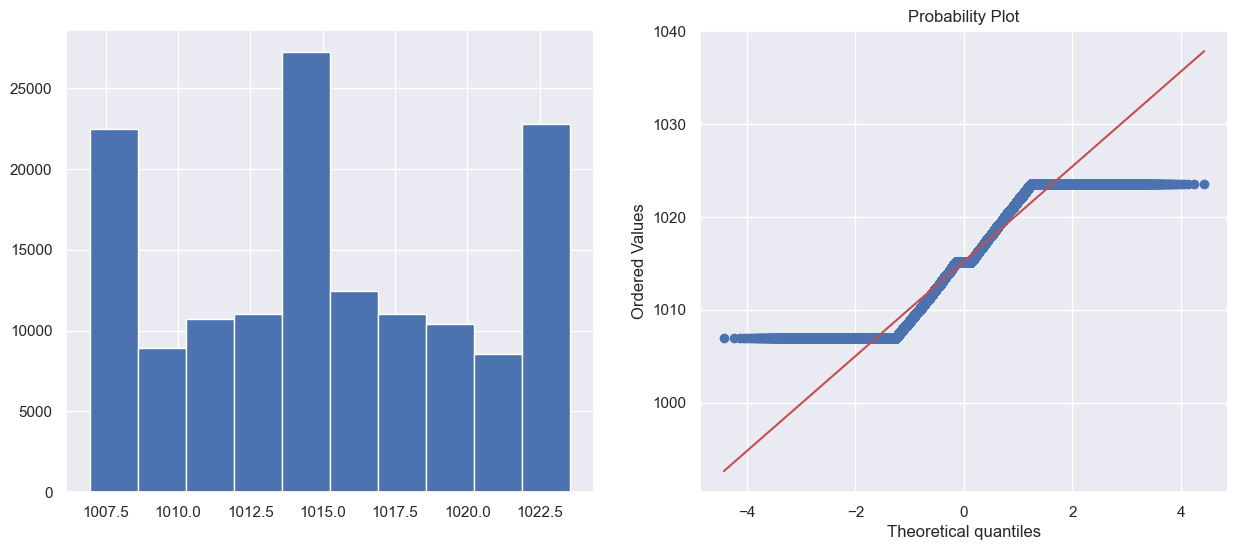

Temp9am


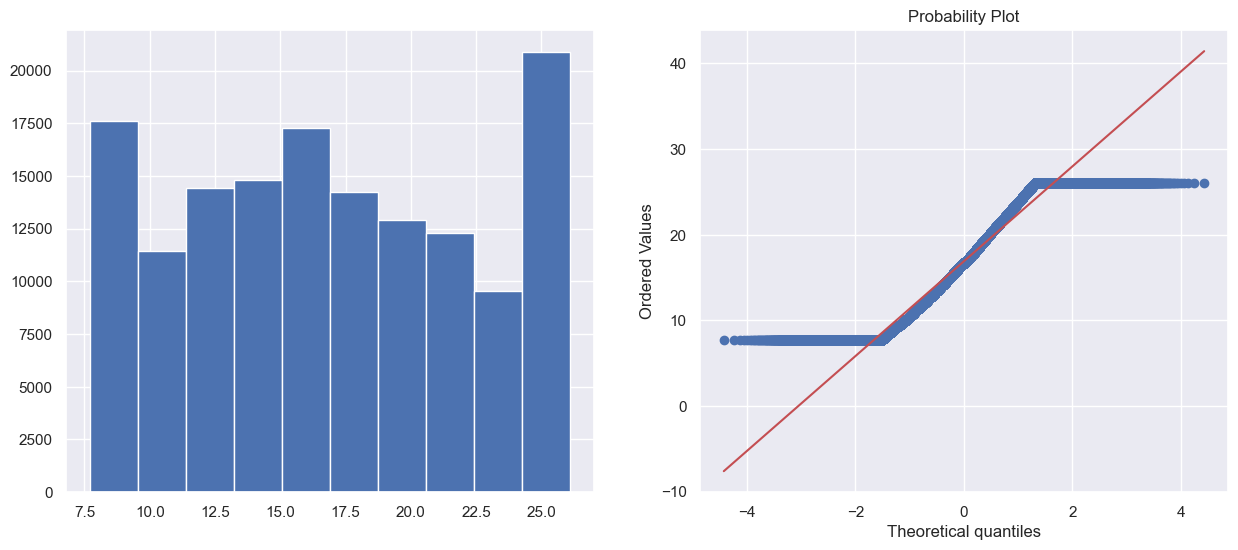

Temp3pm


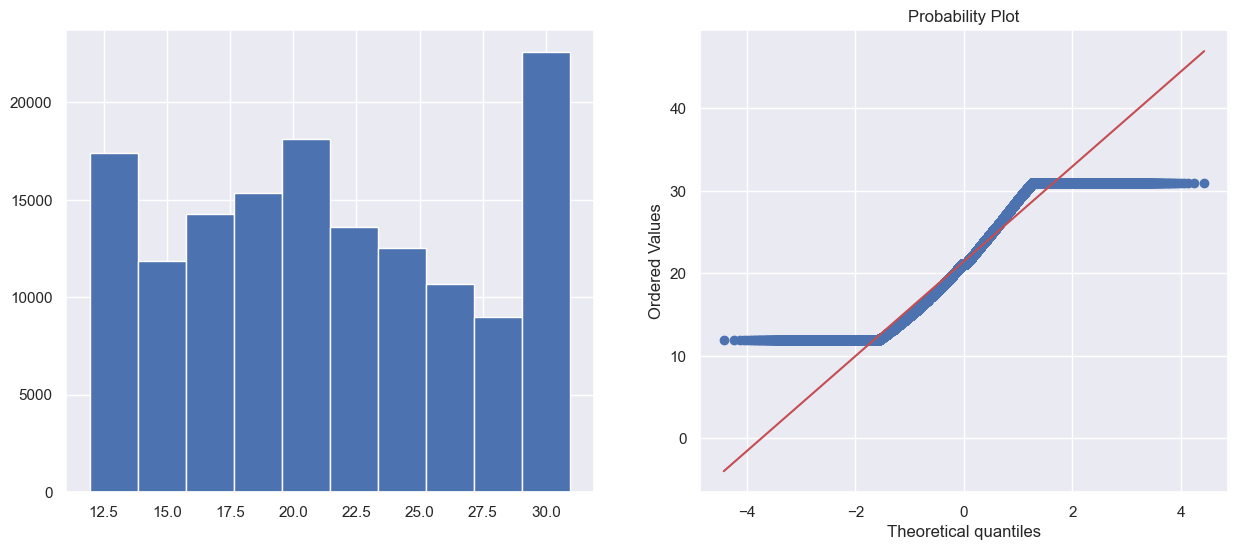

In [36]:
for f in continuousFeatures:
    qq_plot(df, f)

In [37]:
df1 = df.drop(['Date', 'Location'], axis = 1)
df1.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

## Selecting Independent and Dependent Data

In [38]:
X = df1.drop(['RainTomorrow'], axis = 1)
X.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,23.0,1009.35,1007.10,8.0,0.0,16.9,21.8,0
1,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.60,1007.80,7.0,1.0,17.2,24.3,0
2,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,44.0,30.0,1009.35,1008.70,8.0,2.0,21.0,23.2,0
3,9.2,28.0,0.0,9.8,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,23.0,1017.60,1012.80,0.0,5.0,18.1,26.5,0
4,17.5,32.3,0.9,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.80,1006.95,7.0,8.0,17.8,29.7,0


In [39]:
y = df1['RainTomorrow']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: RainTomorrow, dtype: uint8

## Data Transformation

In [40]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled

array([[ 0.2138973 , -0.0256512 ,  0.90931388, ..., -0.00331348,
         0.05455449, -0.52979545],
       [-0.84825402,  0.32526761, -0.66348596, ...,  0.04956796,
         0.47802982, -0.52979545],
       [ 0.12538469,  0.42097274, -0.66348596, ...,  0.71939961,
         0.29170067, -0.52979545],
       ...,
       [-1.20230446,  0.612383  , -0.66348596, ..., -0.77890802,
         0.78293205, -0.52979545],
       [-0.77744393,  0.62833386, -0.66348596, ..., -0.32060216,
         0.76599304, -0.52979545],
       [ 0.47943513, -0.07350377, -0.66348596, ..., -0.33822931,
        -0.09789663, -0.52979545]])

In [41]:
pt = PowerTransformer()
X_ptrans = pt.fit_transform(X)
X_ptrans

array([[ 0.2702902 ,  0.03601798,  1.35965796, ...,  0.04906312,
         0.1105931 , -0.52979545],
       [-0.81517066,  0.37747975, -0.71740796, ...,  0.10116529,
         0.51826614, -0.52979545],
       [ 0.18548186,  0.46825965, -0.71740796, ...,  0.7391628 ,
         0.34110146, -0.52979545],
       ...,
       [-1.22205277,  0.6470214 , -0.71740796, ..., -0.75114566,
         0.80126712, -0.52979545],
       [-0.73721666,  0.66175548, -0.71740796, ..., -0.26967339,
         0.78575839, -0.52979545],
       [ 0.51994811, -0.01165745, -0.71740796, ..., -0.28770676,
        -0.04077437, -0.52979545]])

In [42]:
ms = MinMaxScaler()
X_minmax = ms.fit_transform(X)
X_minmax

array([[0.56318681, 0.49019608, 0.66666667, ..., 0.5       , 0.51842105,
        0.        ],
       [0.23351648, 0.59803922, 0.        , ..., 0.51630435, 0.65      ,
        0.        ],
       [0.53571429, 0.62745098, 0.        , ..., 0.72282609, 0.59210526,
        0.        ],
       ...,
       [0.12362637, 0.68627451, 0.        , ..., 0.26086957, 0.74473684,
        0.        ],
       [0.25549451, 0.69117647, 0.        , ..., 0.40217391, 0.73947368,
        0.        ],
       [0.6456044 , 0.4754902 , 0.        , ..., 0.39673913, 0.47105263,
        0.        ]])

In [43]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled ,y, test_size =0.2, stratify = y, random_state = 0)

In [44]:
Counter(y_train1)

Counter({0: 90866, 1: 25502})

## Upsampling

In [45]:
smote = SMOTE(random_state=0)
X_train1, y_train1 = smote.fit_resample(X_train1, y_train1)
Counter(y_train1)

Counter({0: 90866, 1: 90866})

In [46]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_ptrans ,y, test_size =0.2, stratify = y, random_state = 0)
Counter(y_train2)

Counter({0: 90866, 1: 25502})

In [47]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_minmax ,y, test_size =0.2, stratify = y, random_state = 0)
Counter(y_train3)

Counter({0: 90866, 1: 25502})

In [48]:
X_train2, y_train2 = smote.fit_resample(X_train2, y_train2)
Counter(y_train2)

Counter({0: 90866, 1: 90866})

In [49]:
X_train3, y_train3 = smote.fit_resample(X_train3, y_train3)
Counter(y_train2)

Counter({0: 90866, 1: 90866})

## Using Logistic Regression

In [50]:
lr = LogisticRegression()
lr.fit(X_train3, y_train3)

LogisticRegression()

In [51]:
y_pred3 = lr.predict(X_test3)
print(confusion_matrix(y_test3, y_pred3))
print()
print(accuracy_score(y_test3, y_pred3))
print()
print(classification_report(y_test3, y_pred3))

[[17634  5083]
 [ 1467  4908]]

0.7748521930427609

              precision    recall  f1-score   support

           0       0.92      0.78      0.84     22717
           1       0.49      0.77      0.60      6375

    accuracy                           0.77     29092
   macro avg       0.71      0.77      0.72     29092
weighted avg       0.83      0.77      0.79     29092



0.7730646082617578

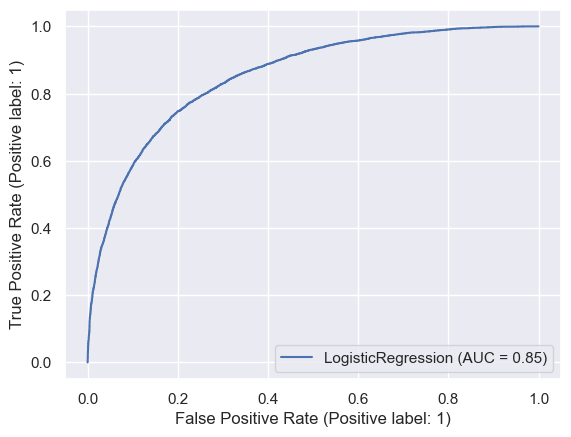

In [52]:
metrics.plot_roc_curve(lr, X_test3, y_test3)
metrics.roc_auc_score(y_test3, y_pred3, average = None)

## Using Gaussian Naive Bayes

In [53]:
gnb = GaussianNB()
gnb.fit(X_train1, y_train1)

GaussianNB()

In [54]:
y_pred1 = gnb.predict(X_test1)
print(confusion_matrix(y_test1, y_pred1))
print()
print(accuracy_score(y_test1, y_pred1))
print()
print(classification_report(y_test1, y_pred1))

[[17179  5538]
 [ 1700  4675]]

0.7512030798845043

              precision    recall  f1-score   support

           0       0.91      0.76      0.83     22717
           1       0.46      0.73      0.56      6375

    accuracy                           0.75     29092
   macro avg       0.68      0.74      0.69     29092
weighted avg       0.81      0.75      0.77     29092



0.7447755718918284

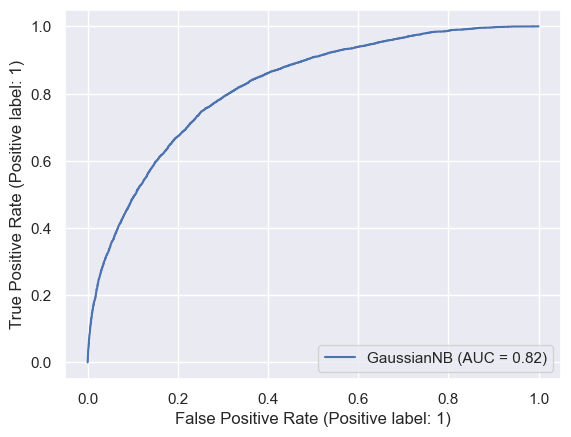

In [55]:
metrics.plot_roc_curve(gnb, X_test1, y_test1)
metrics.roc_auc_score(y_test1, y_pred1, average = None)

## Using KNeighbours Classifiers

In [56]:
knnClassifier = KNeighborsClassifier(n_neighbors = 2)
knnClassifier.fit(X_train1, y_train1)

KNeighborsClassifier(n_neighbors=2)

In [57]:
y_pred1 = knnClassifier.predict(X_test1)
print(confusion_matrix(y_test1, y_pred1))
print()
print(accuracy_score(y_test1, y_pred1))
print()
print(classification_report(y_test1, y_pred1))

[[19430  3287]
 [ 3106  3269]]

0.7802488656675375

              precision    recall  f1-score   support

           0       0.86      0.86      0.86     22717
           1       0.50      0.51      0.51      6375

    accuracy                           0.78     29092
   macro avg       0.68      0.68      0.68     29092
weighted avg       0.78      0.78      0.78     29092



0.6840454561540247

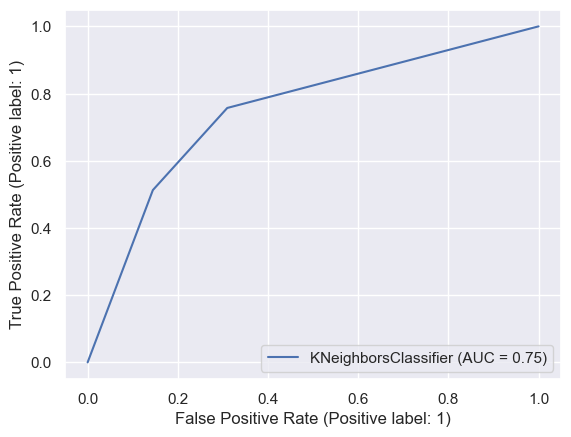

In [58]:
metrics.plot_roc_curve(knnClassifier, X_test1, y_test1)
metrics.roc_auc_score(y_test1, y_pred1, average = None)

## Using Random Forest Classifier

In [59]:
rfClassifier = RandomForestClassifier()
rfClassifier.fit(X_train3, y_train3)

RandomForestClassifier()

In [60]:
y_pred3 = rfClassifier.predict(X_test3)
print(confusion_matrix(y_test3, y_pred3))
print()
print(accuracy_score(y_test3, y_pred3))
print()
print(classification_report(y_test3, y_pred3))

[[20552  2165]
 [ 2470  3905]]

0.8406778495806407

              precision    recall  f1-score   support

           0       0.89      0.90      0.90     22717
           1       0.64      0.61      0.63      6375

    accuracy                           0.84     29092
   macro avg       0.77      0.76      0.76     29092
weighted avg       0.84      0.84      0.84     29092



0.6840454561540247

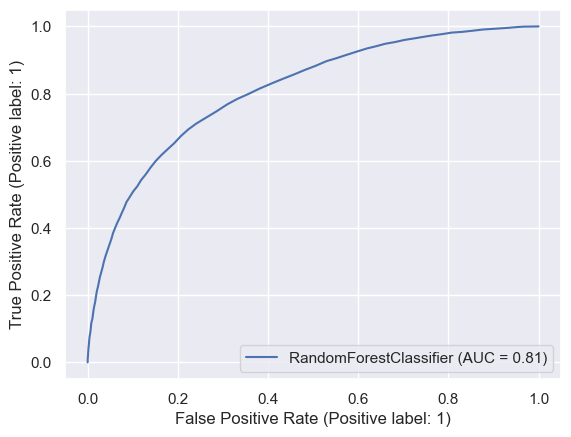

In [61]:
metrics.plot_roc_curve(rfClassifier, X_test1, y_test1)
metrics.roc_auc_score(y_test1, y_pred1, average = None)

## Using XGBClassifier

In [62]:
xgbC = XGBClassifier()
xgbC.fit(X_train1, y_train1)

/opt/homebrew/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:51:16] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [63]:
y_pred1 = xgbC.predict(X_test1)
print(confusion_matrix(y_test1, y_pred1))
print()
print(accuracy_score(y_test1, y_pred1))
print()
print(classification_report(y_test1, y_pred1))

[[21308  1409]
 [ 2925  3450]]

0.851024336587378

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     22717
           1       0.71      0.54      0.61      6375

    accuracy                           0.85     29092
   macro avg       0.79      0.74      0.76     29092
weighted avg       0.84      0.85      0.84     29092



0.7395762178622384

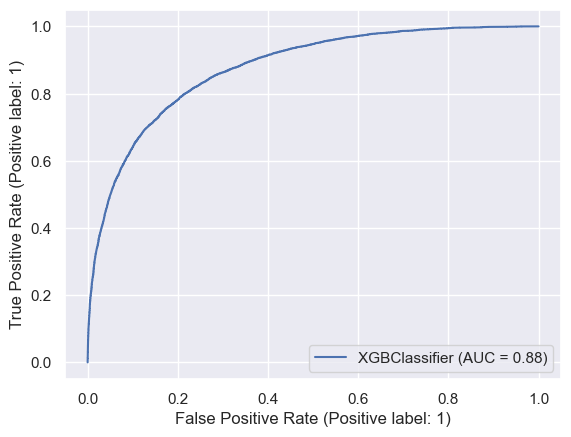

In [64]:
metrics.plot_roc_curve(xgbC, X_test1, y_test1)
metrics.roc_auc_score(y_test1, y_pred1, average = None)

## Using CatBoostClassifier

In [65]:
catBoostC = CatBoostClassifier(iterations = 3000, eval_metric = 'AUC')
catBoostC.fit(X_train1, y_train1)

Learning rate set to 0.034689
0:	total: 70.6ms	remaining: 3m 31s
1:	total: 82.8ms	remaining: 2m 4s
2:	total: 96ms	remaining: 1m 35s
3:	total: 109ms	remaining: 1m 21s
4:	total: 122ms	remaining: 1m 12s
5:	total: 135ms	remaining: 1m 7s
6:	total: 148ms	remaining: 1m 3s
7:	total: 161ms	remaining: 1m
8:	total: 174ms	remaining: 57.7s
9:	total: 186ms	remaining: 55.6s
10:	total: 199ms	remaining: 53.9s
11:	total: 213ms	remaining: 53.1s
12:	total: 226ms	remaining: 52s
13:	total: 239ms	remaining: 50.9s
14:	total: 252ms	remaining: 50.1s
15:	total: 264ms	remaining: 49.2s
16:	total: 277ms	remaining: 48.6s
17:	total: 290ms	remaining: 48s
18:	total: 302ms	remaining: 47.4s
19:	total: 315ms	remaining: 46.9s
20:	total: 328ms	remaining: 46.5s
21:	total: 340ms	remaining: 46s
22:	total: 353ms	remaining: 45.7s
23:	total: 366ms	remaining: 45.4s
24:	total: 378ms	remaining: 45s
25:	total: 391ms	remaining: 44.8s
26:	total: 404ms	remaining: 44.5s
27:	total: 420ms	remaining: 44.6s
28:	total: 432ms	remaining: 44.3s


250:	total: 3.34s	remaining: 36.6s
251:	total: 3.35s	remaining: 36.6s
252:	total: 3.37s	remaining: 36.5s
253:	total: 3.38s	remaining: 36.5s
254:	total: 3.39s	remaining: 36.5s
255:	total: 3.4s	remaining: 36.5s
256:	total: 3.42s	remaining: 36.5s
257:	total: 3.43s	remaining: 36.5s
258:	total: 3.44s	remaining: 36.4s
259:	total: 3.46s	remaining: 36.4s
260:	total: 3.47s	remaining: 36.4s
261:	total: 3.48s	remaining: 36.4s
262:	total: 3.49s	remaining: 36.4s
263:	total: 3.51s	remaining: 36.3s
264:	total: 3.52s	remaining: 36.3s
265:	total: 3.53s	remaining: 36.3s
266:	total: 3.54s	remaining: 36.3s
267:	total: 3.56s	remaining: 36.3s
268:	total: 3.57s	remaining: 36.3s
269:	total: 3.58s	remaining: 36.3s
270:	total: 3.6s	remaining: 36.2s
271:	total: 3.61s	remaining: 36.2s
272:	total: 3.62s	remaining: 36.2s
273:	total: 3.64s	remaining: 36.2s
274:	total: 3.65s	remaining: 36.2s
275:	total: 3.66s	remaining: 36.1s
276:	total: 3.67s	remaining: 36.1s
277:	total: 3.69s	remaining: 36.1s
278:	total: 3.7s	remai

500:	total: 6.66s	remaining: 33.2s
501:	total: 6.67s	remaining: 33.2s
502:	total: 6.69s	remaining: 33.2s
503:	total: 6.7s	remaining: 33.2s
504:	total: 6.71s	remaining: 33.2s
505:	total: 6.73s	remaining: 33.2s
506:	total: 6.74s	remaining: 33.2s
507:	total: 6.76s	remaining: 33.2s
508:	total: 6.77s	remaining: 33.2s
509:	total: 6.79s	remaining: 33.2s
510:	total: 6.8s	remaining: 33.1s
511:	total: 6.82s	remaining: 33.1s
512:	total: 6.84s	remaining: 33.1s
513:	total: 6.85s	remaining: 33.1s
514:	total: 6.86s	remaining: 33.1s
515:	total: 6.88s	remaining: 33.1s
516:	total: 6.89s	remaining: 33.1s
517:	total: 6.91s	remaining: 33.1s
518:	total: 6.92s	remaining: 33.1s
519:	total: 6.94s	remaining: 33.1s
520:	total: 6.95s	remaining: 33.1s
521:	total: 6.96s	remaining: 33.1s
522:	total: 6.98s	remaining: 33s
523:	total: 6.99s	remaining: 33s
524:	total: 7s	remaining: 33s
525:	total: 7.02s	remaining: 33s
526:	total: 7.03s	remaining: 33s
527:	total: 7.05s	remaining: 33s
528:	total: 7.06s	remaining: 33s
529:

737:	total: 10.2s	remaining: 31.2s
738:	total: 10.2s	remaining: 31.2s
739:	total: 10.2s	remaining: 31.2s
740:	total: 10.2s	remaining: 31.2s
741:	total: 10.2s	remaining: 31.2s
742:	total: 10.3s	remaining: 31.1s
743:	total: 10.3s	remaining: 31.1s
744:	total: 10.3s	remaining: 31.1s
745:	total: 10.3s	remaining: 31.1s
746:	total: 10.3s	remaining: 31.1s
747:	total: 10.3s	remaining: 31.1s
748:	total: 10.3s	remaining: 31.1s
749:	total: 10.4s	remaining: 31.1s
750:	total: 10.4s	remaining: 31.1s
751:	total: 10.4s	remaining: 31.1s
752:	total: 10.4s	remaining: 31.1s
753:	total: 10.4s	remaining: 31.1s
754:	total: 10.4s	remaining: 31s
755:	total: 10.5s	remaining: 31s
756:	total: 10.5s	remaining: 31s
757:	total: 10.5s	remaining: 31s
758:	total: 10.5s	remaining: 31s
759:	total: 10.5s	remaining: 31s
760:	total: 10.5s	remaining: 31s
761:	total: 10.5s	remaining: 31s
762:	total: 10.6s	remaining: 31s
763:	total: 10.6s	remaining: 31s
764:	total: 10.6s	remaining: 30.9s
765:	total: 10.6s	remaining: 30.9s
766:	

974:	total: 13.7s	remaining: 28.5s
975:	total: 13.7s	remaining: 28.4s
976:	total: 13.7s	remaining: 28.4s
977:	total: 13.7s	remaining: 28.4s
978:	total: 13.8s	remaining: 28.4s
979:	total: 13.8s	remaining: 28.4s
980:	total: 13.8s	remaining: 28.4s
981:	total: 13.8s	remaining: 28.4s
982:	total: 13.8s	remaining: 28.4s
983:	total: 13.8s	remaining: 28.3s
984:	total: 13.8s	remaining: 28.3s
985:	total: 13.9s	remaining: 28.3s
986:	total: 13.9s	remaining: 28.3s
987:	total: 13.9s	remaining: 28.3s
988:	total: 13.9s	remaining: 28.3s
989:	total: 13.9s	remaining: 28.3s
990:	total: 13.9s	remaining: 28.2s
991:	total: 13.9s	remaining: 28.2s
992:	total: 14s	remaining: 28.2s
993:	total: 14s	remaining: 28.2s
994:	total: 14s	remaining: 28.2s
995:	total: 14s	remaining: 28.2s
996:	total: 14s	remaining: 28.1s
997:	total: 14s	remaining: 28.1s
998:	total: 14s	remaining: 28.1s
999:	total: 14s	remaining: 28.1s
1000:	total: 14.1s	remaining: 28.1s
1001:	total: 14.1s	remaining: 28.1s
1002:	total: 14.1s	remaining: 28s


1206:	total: 16.8s	remaining: 25s
1207:	total: 16.8s	remaining: 25s
1208:	total: 16.8s	remaining: 24.9s
1209:	total: 16.9s	remaining: 24.9s
1210:	total: 16.9s	remaining: 24.9s
1211:	total: 16.9s	remaining: 24.9s
1212:	total: 16.9s	remaining: 24.9s
1213:	total: 16.9s	remaining: 24.9s
1214:	total: 16.9s	remaining: 24.9s
1215:	total: 16.9s	remaining: 24.8s
1216:	total: 16.9s	remaining: 24.8s
1217:	total: 17s	remaining: 24.8s
1218:	total: 17s	remaining: 24.8s
1219:	total: 17s	remaining: 24.8s
1220:	total: 17s	remaining: 24.8s
1221:	total: 17s	remaining: 24.7s
1222:	total: 17s	remaining: 24.7s
1223:	total: 17s	remaining: 24.7s
1224:	total: 17s	remaining: 24.7s
1225:	total: 17.1s	remaining: 24.7s
1226:	total: 17.1s	remaining: 24.7s
1227:	total: 17.1s	remaining: 24.6s
1228:	total: 17.1s	remaining: 24.6s
1229:	total: 17.1s	remaining: 24.6s
1230:	total: 17.1s	remaining: 24.6s
1231:	total: 17.1s	remaining: 24.6s
1232:	total: 17.1s	remaining: 24.6s
1233:	total: 17.2s	remaining: 24.6s
1234:	total:

1446:	total: 19.9s	remaining: 21.4s
1447:	total: 19.9s	remaining: 21.3s
1448:	total: 19.9s	remaining: 21.3s
1449:	total: 19.9s	remaining: 21.3s
1450:	total: 20s	remaining: 21.3s
1451:	total: 20s	remaining: 21.3s
1452:	total: 20s	remaining: 21.3s
1453:	total: 20s	remaining: 21.3s
1454:	total: 20s	remaining: 21.2s
1455:	total: 20s	remaining: 21.2s
1456:	total: 20s	remaining: 21.2s
1457:	total: 20s	remaining: 21.2s
1458:	total: 20.1s	remaining: 21.2s
1459:	total: 20.1s	remaining: 21.2s
1460:	total: 20.1s	remaining: 21.2s
1461:	total: 20.1s	remaining: 21.1s
1462:	total: 20.1s	remaining: 21.1s
1463:	total: 20.1s	remaining: 21.1s
1464:	total: 20.1s	remaining: 21.1s
1465:	total: 20.1s	remaining: 21.1s
1466:	total: 20.2s	remaining: 21.1s
1467:	total: 20.2s	remaining: 21.1s
1468:	total: 20.2s	remaining: 21s
1469:	total: 20.2s	remaining: 21s
1470:	total: 20.2s	remaining: 21s
1471:	total: 20.2s	remaining: 21s
1472:	total: 20.2s	remaining: 21s
1473:	total: 20.3s	remaining: 21s
1474:	total: 20.3s	r

1691:	total: 23.3s	remaining: 18s
1692:	total: 23.3s	remaining: 18s
1693:	total: 23.3s	remaining: 18s
1694:	total: 23.3s	remaining: 17.9s
1695:	total: 23.3s	remaining: 17.9s
1696:	total: 23.3s	remaining: 17.9s
1697:	total: 23.3s	remaining: 17.9s
1698:	total: 23.4s	remaining: 17.9s
1699:	total: 23.4s	remaining: 17.9s
1700:	total: 23.4s	remaining: 17.9s
1701:	total: 23.4s	remaining: 17.9s
1702:	total: 23.4s	remaining: 17.8s
1703:	total: 23.4s	remaining: 17.8s
1704:	total: 23.5s	remaining: 17.8s
1705:	total: 23.5s	remaining: 17.8s
1706:	total: 23.5s	remaining: 17.8s
1707:	total: 23.5s	remaining: 17.8s
1708:	total: 23.5s	remaining: 17.8s
1709:	total: 23.5s	remaining: 17.7s
1710:	total: 23.5s	remaining: 17.7s
1711:	total: 23.6s	remaining: 17.7s
1712:	total: 23.6s	remaining: 17.7s
1713:	total: 23.6s	remaining: 17.7s
1714:	total: 23.6s	remaining: 17.7s
1715:	total: 23.6s	remaining: 17.7s
1716:	total: 23.6s	remaining: 17.6s
1717:	total: 23.6s	remaining: 17.6s
1718:	total: 23.6s	remaining: 17.6

1933:	total: 26.6s	remaining: 14.6s
1934:	total: 26.6s	remaining: 14.6s
1935:	total: 26.6s	remaining: 14.6s
1936:	total: 26.6s	remaining: 14.6s
1937:	total: 26.6s	remaining: 14.6s
1938:	total: 26.6s	remaining: 14.6s
1939:	total: 26.7s	remaining: 14.6s
1940:	total: 26.7s	remaining: 14.6s
1941:	total: 26.7s	remaining: 14.5s
1942:	total: 26.7s	remaining: 14.5s
1943:	total: 26.7s	remaining: 14.5s
1944:	total: 26.7s	remaining: 14.5s
1945:	total: 26.7s	remaining: 14.5s
1946:	total: 26.7s	remaining: 14.5s
1947:	total: 26.8s	remaining: 14.5s
1948:	total: 26.8s	remaining: 14.4s
1949:	total: 26.8s	remaining: 14.4s
1950:	total: 26.8s	remaining: 14.4s
1951:	total: 26.8s	remaining: 14.4s
1952:	total: 26.8s	remaining: 14.4s
1953:	total: 26.8s	remaining: 14.4s
1954:	total: 26.9s	remaining: 14.4s
1955:	total: 26.9s	remaining: 14.3s
1956:	total: 26.9s	remaining: 14.3s
1957:	total: 26.9s	remaining: 14.3s
1958:	total: 26.9s	remaining: 14.3s
1959:	total: 26.9s	remaining: 14.3s
1960:	total: 26.9s	remaining

2174:	total: 30.1s	remaining: 11.4s
2175:	total: 30.1s	remaining: 11.4s
2176:	total: 30.1s	remaining: 11.4s
2177:	total: 30.1s	remaining: 11.4s
2178:	total: 30.1s	remaining: 11.4s
2179:	total: 30.2s	remaining: 11.3s
2180:	total: 30.2s	remaining: 11.3s
2181:	total: 30.2s	remaining: 11.3s
2182:	total: 30.2s	remaining: 11.3s
2183:	total: 30.2s	remaining: 11.3s
2184:	total: 30.2s	remaining: 11.3s
2185:	total: 30.2s	remaining: 11.3s
2186:	total: 30.2s	remaining: 11.2s
2187:	total: 30.3s	remaining: 11.2s
2188:	total: 30.3s	remaining: 11.2s
2189:	total: 30.3s	remaining: 11.2s
2190:	total: 30.3s	remaining: 11.2s
2191:	total: 30.3s	remaining: 11.2s
2192:	total: 30.3s	remaining: 11.2s
2193:	total: 30.3s	remaining: 11.1s
2194:	total: 30.4s	remaining: 11.1s
2195:	total: 30.4s	remaining: 11.1s
2196:	total: 30.4s	remaining: 11.1s
2197:	total: 30.4s	remaining: 11.1s
2198:	total: 30.4s	remaining: 11.1s
2199:	total: 30.4s	remaining: 11.1s
2200:	total: 30.4s	remaining: 11s
2201:	total: 30.4s	remaining: 

2416:	total: 33.4s	remaining: 8.06s
2417:	total: 33.4s	remaining: 8.05s
2418:	total: 33.4s	remaining: 8.03s
2419:	total: 33.5s	remaining: 8.02s
2420:	total: 33.5s	remaining: 8.01s
2421:	total: 33.5s	remaining: 7.99s
2422:	total: 33.5s	remaining: 7.98s
2423:	total: 33.5s	remaining: 7.96s
2424:	total: 33.5s	remaining: 7.95s
2425:	total: 33.5s	remaining: 7.93s
2426:	total: 33.5s	remaining: 7.92s
2427:	total: 33.6s	remaining: 7.91s
2428:	total: 33.6s	remaining: 7.89s
2429:	total: 33.6s	remaining: 7.88s
2430:	total: 33.6s	remaining: 7.86s
2431:	total: 33.6s	remaining: 7.85s
2432:	total: 33.6s	remaining: 7.84s
2433:	total: 33.6s	remaining: 7.82s
2434:	total: 33.7s	remaining: 7.81s
2435:	total: 33.7s	remaining: 7.79s
2436:	total: 33.7s	remaining: 7.78s
2437:	total: 33.7s	remaining: 7.77s
2438:	total: 33.7s	remaining: 7.75s
2439:	total: 33.7s	remaining: 7.74s
2440:	total: 33.7s	remaining: 7.73s
2441:	total: 33.8s	remaining: 7.71s
2442:	total: 33.8s	remaining: 7.7s
2443:	total: 33.8s	remaining:

2650:	total: 36.5s	remaining: 4.81s
2651:	total: 36.6s	remaining: 4.8s
2652:	total: 36.6s	remaining: 4.78s
2653:	total: 36.6s	remaining: 4.77s
2654:	total: 36.6s	remaining: 4.75s
2655:	total: 36.6s	remaining: 4.74s
2656:	total: 36.6s	remaining: 4.73s
2657:	total: 36.6s	remaining: 4.71s
2658:	total: 36.6s	remaining: 4.7s
2659:	total: 36.7s	remaining: 4.68s
2660:	total: 36.7s	remaining: 4.67s
2661:	total: 36.7s	remaining: 4.66s
2662:	total: 36.7s	remaining: 4.64s
2663:	total: 36.7s	remaining: 4.63s
2664:	total: 36.7s	remaining: 4.62s
2665:	total: 36.7s	remaining: 4.6s
2666:	total: 36.7s	remaining: 4.59s
2667:	total: 36.8s	remaining: 4.57s
2668:	total: 36.8s	remaining: 4.56s
2669:	total: 36.8s	remaining: 4.55s
2670:	total: 36.8s	remaining: 4.53s
2671:	total: 36.8s	remaining: 4.52s
2672:	total: 36.8s	remaining: 4.5s
2673:	total: 36.8s	remaining: 4.49s
2674:	total: 36.9s	remaining: 4.48s
2675:	total: 36.9s	remaining: 4.46s
2676:	total: 36.9s	remaining: 4.45s
2677:	total: 36.9s	remaining: 4.

2881:	total: 39.6s	remaining: 1.62s
2882:	total: 39.7s	remaining: 1.61s
2883:	total: 39.7s	remaining: 1.59s
2884:	total: 39.7s	remaining: 1.58s
2885:	total: 39.7s	remaining: 1.57s
2886:	total: 39.7s	remaining: 1.55s
2887:	total: 39.7s	remaining: 1.54s
2888:	total: 39.7s	remaining: 1.53s
2889:	total: 39.8s	remaining: 1.51s
2890:	total: 39.8s	remaining: 1.5s
2891:	total: 39.8s	remaining: 1.49s
2892:	total: 39.8s	remaining: 1.47s
2893:	total: 39.8s	remaining: 1.46s
2894:	total: 39.8s	remaining: 1.44s
2895:	total: 39.8s	remaining: 1.43s
2896:	total: 39.8s	remaining: 1.42s
2897:	total: 39.9s	remaining: 1.4s
2898:	total: 39.9s	remaining: 1.39s
2899:	total: 39.9s	remaining: 1.38s
2900:	total: 39.9s	remaining: 1.36s
2901:	total: 39.9s	remaining: 1.35s
2902:	total: 39.9s	remaining: 1.33s
2903:	total: 39.9s	remaining: 1.32s
2904:	total: 39.9s	remaining: 1.31s
2905:	total: 40s	remaining: 1.29s
2906:	total: 40s	remaining: 1.28s
2907:	total: 40s	remaining: 1.26s
2908:	total: 40s	remaining: 1.25s
29

In [66]:
y_pred1 = catBoostC.predict(X_test1)
print(confusion_matrix(y_test1, y_pred1))
print()
print(accuracy_score(y_test1, y_pred1))
print()
print(classification_report(y_test1, y_pred1))

[[21416  1301]
 [ 2891  3484]]

0.855905403547367

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     22717
           1       0.73      0.55      0.62      6375

    accuracy                           0.86     29092
   macro avg       0.80      0.74      0.77     29092
weighted avg       0.85      0.86      0.85     29092



0.744619958966551

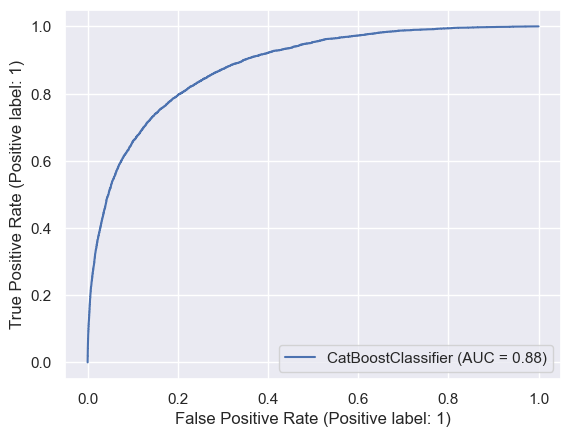

In [67]:
metrics.plot_roc_curve(catBoostC, X_test1, y_test1)
metrics.roc_auc_score(y_test1, y_pred1, average = None)

## Exporting Binary Files for the Built Models

In [68]:
# best model to be selected based on performance
joblib.dump(lr,'logisticRegression.pkl')
joblib.dump(gnb,'gaussianNB.pkl')
joblib.dump(knnClassifier,'knnClassifier.pkl')
joblib.dump(rfClassifier,'rfClassifier.pkl')
joblib.dump(xgbC,'xgbClassifier.pkl')
joblib.dump(catBoostC,'catBoostClassifier.pkl')

['catBoostClassifier.pkl']